In [2]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

from tqdm import tqdm
from statsmodels.tsa.seasonal import STL

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

from collections import defaultdict 


import sys 
sys.path.insert(1, "../")


from workloads.util import use_dataset
import seaborn as sns
sns.set(style='whitegrid', palette='muted')

%load_ext autoreload
%autoreload 2

* STLForecast does poorly due to anomalies 
* Results basicaly a function of if it overlapped with an anomaly or not 
* Potentally remove the anomalies (?) - fill in with previously predicted chunk 
* Try window size 24-48 (?) + smaller slide sizes 
* round robin streaming vs. policies 

In [3]:
dataset_dir = use_dataset("yahoo/A1", download=True)

/data/wooders/ralf-vldb//datasets/yahoo/A1


In [4]:
WINDOW_SIZE = 48
NUM_KEYS = 15

In [5]:
def remove_anomaly(df): 
    for index, row in df.iterrows(): 
        if not row["is_anomaly"] or index < WINDOW_SIZE: continue 
            
        chunk = df.iloc[index-WINDOW_SIZE:index].value
        model = STLForecast(
            chunk, ARIMA, model_kwargs=dict(order=(1, 1, 0), trend="t"), period=24
        ).fit()
        row["value"] = model.forecast(1).tolist()[0]
        df.iloc[index] = pd.Series(row)

    return df

In [6]:
def compute_policy_error(arr, update_times, start, length=None):
    """
    Compute single-key errors given a list of update timestamps 
    
    :arr: data array for key  
    :update_times: list of timesteps to update for key 
    :start: starting point of eval
    """

    if not length: 
        length = len(arr) - start 
      
    update_times = sorted(update_times)
    
    # compute start model 
    chunk = arr[start - WINDOW_SIZE : start]
    last_model = STLForecast(
        chunk, ARIMA, model_kwargs=dict(order=(1, 1, 0), trend="t"), period=24
    ).fit().forecast(2000).tolist()
    last_time = start 
    
    y_pred = []
    for i in range(len(update_times)):
        ts = update_times[i]
        assert ts <= start + length 
        chunk = arr[ts - WINDOW_SIZE : ts]
        
        # evaluate with last model 
        y_pred += last_model[: ts - last_time]
        
        # train new model
        last_model = STLForecast(
            chunk, ARIMA, model_kwargs=dict(order=(1, 1, 0), trend="t"), period=24, robust=True
        ).fit()
        #print(last_model.summary())
        last_model = last_model.forecast(2000).tolist()
        last_time = ts
        

    # fill in remaining predictions 
    y_pred += last_model[: start + length - last_time]
    
    y_true = arr[start : start + length]
    if len(y_pred) != len(y_true): 
        print("pred", len(y_pred), len(last_model[: length - last_time]), length - last_time, "true", len(y_true))
        assert False 
    return y_pred, y_true 

def slide_update_times(start, length, slide_size): 
    return [ts for ts in range(start, start + length, slide_size)]

def n_fits_update_times(start, length, n_fits): 
    slide_size = round(length / n_fits)
    return slide_update_times(start, length, slide_size)

In [7]:
def get_residual(arr):
    model = STL(arr, period=24, robust=True).fit()
    return model.resid

# Non-Streaming Simulation

In [1834]:
results = []
start = WINDOW_SIZE 
length = WINDOW_SIZE*6
for i in tqdm(range(1, num_keys)):
    df = remove_anomaly(pd.read_csv(f"{dataset_dir}/{i}.csv"))
    arr = df.value.values[:1400] # make same length
    resid = get_residual(arr[start:start+length])
    for slide_size in [12, 24, 48, 96]:
        update_times = slide_update_times(start, length, slide_size)
        y_pred, y_true = compute_policy_error(arr, update_times, start, length)
        
        pred_resid = y_true - y_pred 
        error = mean_absolute_scaled_error(resid, pred_resid, y_train=y_true, sp=24)
        #error = mean_absolute_scaled_error(y_true, y_pred, y_train=y_true, sp=24)
        results.append({"key": i, "slide_size": slide_size, "error": error, "n_fits": len(update_times)})

100%|██████████| 14/14 [01:40<00:00,  7.21s/it]


In [1835]:
df = pd.DataFrame(results)

In [1836]:
df[df["key"] == 2]

,key,slide_size,error,n_fits
4,2,12,1.193648,24
5,2,24,1.538200,12
6,2,48,2.363206,6
7,2,96,4.115213,3


In [1837]:
from workloads.stl.config_gen import run_lp
from pprint import pprint

## Baseline results 
Baseline results generated with a static baseline 

In [1150]:
start= WINDOW_SIZE*1
length = WINDOW_SIZE*6

48 288


In [1151]:
slide_size = 48

In [1838]:
static_fits = [] 
static_error = []
for i in tqdm(range(1, num_keys)):
    df = remove_anomaly(pd.read_csv(f"{dataset_dir}/{i}.csv"))
    arr = df.value.values[:1400] # make same length
    resid = get_residual(arr[start:start+length])
    slide_times = slide_update_times(start, length, slide_size)
    
    y_pred, y_true = compute_policy_error(arr, slide_times, start, length)
    pred_resid = y_true - y_pred
    error = mean_absolute_scaled_error(resid, pred_resid, y_train=y_true, sp=24)
    
    static_fits.append(len(slide_times))
    static_error.append(error)
    

print(static_fits)
print(static_error)
print("TOTAL FITS", sum(static_fits))
print("TOTAL ERROR", sum(static_error))

100%|██████████| 14/14 [00:35<00:00,  2.51s/it]

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[1.0330373997661204, 4.115213382568746, 2.6973890531481186, 1.16578867089961, 1.8410999231064396, 2.7789827427278277, 3.6093908322750736, 1.110974809037846, 2.43632378936999, 1.4983607536829764, 1.426429378166745, 1.5115364121839014, 2.772899927701818, 3.1781141295383937]
TOTAL FITS 42
TOTAL ERROR 31.175541204173605


## LP Results 
LP results should be better for the "test" data, otherwise there is probably not much to learn for the model. 

In [1839]:
cost = sum(static_fits)
cost
# NOTE: this assumes the length of the data is the same as for training 

42

In [1840]:
lp_df = pd.DataFrame(results)
lp_df["loss"] = lp_df["error"]
lp_df = lp_df[["key", "n_fits", "loss"]]
plan_output, optimal_loss = run_lp(lp_df, max_n_fits=cost, objective="min_loss")
pprint(plan_output)
print(sum(list(plan_output.values())))

{1: 3,
 2: 3,
 3: 3,
 4: 3,
 5: 3,
 6: 3,
 7: 3,
 8: 3,
 9: 3,
 10: 3,
 11: 3,
 12: 3,
 13: 3,
 14: 3}
42


In [1841]:
lp_fits = [] 
lp_error = []
for i in tqdm(range(1, num_keys)):
    df = remove_anomaly(pd.read_csv(f"{dataset_dir}/{i}.csv"))
    arr = df.value.values[:1400] # make same length
    resid = get_residual(arr[start:start+length])
    slide_times = n_fits_update_times(start, length, plan_output[i])
    y_pred, y_true = compute_policy_error(arr, slide_times, start, length)
    pred_resid = y_true - y_pred
    error = mean_absolute_scaled_error(resid, pred_resid, y_train=y_true, sp=24)
    
    lp_fits.append(len(slide_times))
    lp_error.append(error)

print(lp_fits, lp_error)
print(sum(lp_fits))
print(sum(lp_error))

100%|██████████| 14/14 [00:33<00:00,  2.41s/it]

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3] [1.0330373997661204, 4.115213382568746, 2.6973890531481186, 1.16578867089961, 1.8410999231064396, 2.7789827427278277, 3.6093908322750736, 1.110974809037846, 2.43632378936999, 1.4983607536829764, 1.426429378166745, 1.5115364121839014, 2.772899927701818, 3.1781141295383937]
42
31.175541204173605


# Streaming Simulation

In [8]:
NUM_KEYS = 66
MAX_LEN = 700 

In [9]:
data = {}
for i in tqdm(range(1, NUM_KEYS+1)):
    df = remove_anomaly(pd.read_csv(f"{dataset_dir}/{i}.csv"))
    print(len(df.index))
    arr = df.value.values 
    data[i] = arr 

  2%|██▋                                                                                                                                                                              | 1/66 [00:01<01:05,  1.00s/it]

1420


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

1439


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

1461


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  8%|█████████████▍                                                                                                                                                                   | 5/66 [00:04<00:45,  1.34it/s]

1423
1439


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  9%|████████████████                                                                                                                                                                 | 6/66 [00:05<00:45,  1.32it/s]

1439


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

1423


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

1420


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

1461


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

1439


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

1439


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 18%|████████████████████████████████                                                                                                                                                | 12/66 [00:18<01:15,  1.40s/it]

1439


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 20%|██████████████████████████████████▋

1439


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 21%|█████████████████████████████████████▎                                                                                                                                          | 14/66 [00:20<00:53,  1.03s/it]

1439


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 23%|███████████████████████████████████

1439


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 24%|██████████████████████████████████████████▋                                                                                                                                     | 16/66 [00:21<00:38,  1.30it/s]

1461


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

1424


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 27%|████████████████████████████████████████████████                                                                                                                                | 18/66 [00:48<04:57,  6.20s/it]/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1461


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

1424


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

1422


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 32%|████████████████████████████████████████████████████████                                                                                                                        | 21/66 [01:16<04:56,  6.58s/it]

1420


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

1420


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

1420


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

1461


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

1435


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

1435


 41%|████████████████████████████████████████████████████████████████████████                                                                                                        | 27/66 [01:41<02:45,  4.24s/it]

1427


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

1441


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

1441


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 45%|███████████████████████████████████

1461


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

1427


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

 48%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 32/66 [02:02<02:19,  4.09s/it]/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 33/66 [02:02<01:36,  2.92s/it]

1427
1439


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 52%|███████████████████████████████████

1427
1427


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 55%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 36/66 [02:05<00:46,  1.54s/it]

1461


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

1434


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

1427


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

1427


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 40/66 [02:21<01:39,  3.83s/it]

1427


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 41/66 [02:21<01:10,  2.81s/it]

1435


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

1440


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

1440


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 68%|███████████████████████████████████

1461
1440


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

1441


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 71%|███████████████████████████████████

1427


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

1439


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 49/66 [02:46<00:40,  2.40s/it]

1461


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 50/66 [02:47<00:31,  1.99s/it]

1439


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 51/66 [02:47<00:23,  1.55s/it]

1427


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

1432


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

1461


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 54/66 [02:51<00:15,  1.28s/it]/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


741


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 55/66 [02:52<00:11,  1.04s/it]/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmode

1427


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 56/66 [02:52<00:09,  1.09it/s]

1427


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 57/66 [02:53<00:06,  1.37it/s]

1441


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

1435
1423


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

1461


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

1441


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 62/66 [03:03<00:06,  1.52s/it]

741


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

1439
1441


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

1424


/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eecs/wooders/miniconda3/lib/python

1424


# Hueristic Simulation 

In [10]:
def get_model(key, ts): 

    chunk = data[key][ts - WINDOW_SIZE : ts]
    last_model = STLForecast(
        chunk, ARIMA, model_kwargs=dict(order=(1, 1, 0), trend="t"), period=24
    ).fit()
    #print("new model", key, ts, last_model.model_result.mse, last_model)
    return {"model": last_model, "forecast": last_model.forecast(2000), "data": chunk, "time": ts}


In [11]:
def experiment(test_start, policy, runtime=None, num_updates=None):

    predictions = defaultdict(list)
    values = defaultdict(list)
    staleness = defaultdict(list)
    score = [0 for i in range(1, NUM_KEYS+1, 1)]
    update_times = defaultdict(list)
    
    last_model = {key: get_model(key, test_start) for key in range(1, NUM_KEYS+1, 1)} 
    next_update_time = test_start + runtime # time when model is completed

    for ts in tqdm(range(test_start, MAX_LEN, 1)):
        #print(total_error)

        # run predictions per key 
        for key in last_model.keys(): 
            last_time = last_model[key]["time"]
            predictions[key].append(last_model[key]["forecast"][ts-last_time])
            values[key].append(float(data[key][ts]))
            staleness[key].append(ts-last_time)

            # policy scoring
            t = ts - last_time
            if policy == "total_error" and len(predictions[key]) > 1 and t > 1: 
                e = mean_absolute_scaled_error(
                    np.array(values[key][-t:]), 
                    np.array(predictions[key][-t:]), 
                    y_train=np.array(values[key][-t:]), 
                    sp=1
                )
                score[key-1] = e * t # use total, not mean 
            elif policy == "round_robin": 
                score[key-1] += 1
            elif policy == "max_staleness": 
                score[key-1] = ts-last_time

        if runtime is None: 
            for i in range(num_updates):
            # pick max error key 
                key = np.array(score).argmax() + 1
                #print(key, score)

                # mark as update time for key  
                update_times[key].append(ts) 
                last_model[key] = get_model(key, ts)
                score[key-1] = 0
                
        # can update model
        elif ts >= next_update_time: 
            # pick max error key 
            key = np.array(score).argmax() + 1
            #print(key, score)
            
            # mark as update time for key  
            update_times[key].append(ts) 
            last_model[key] = get_model(key, ts)
            score[key-1] = 0
            
            # update next update time 
            next_update_time += runtime

    results_df = pd.concat([
        pd.DataFrame({
            "y_pred": predictions[key], 
            "y_true": values[key], 
            "staleness": staleness[key], 
            "key": [key] * len(predictions[key])
        })
        for key in predictions.keys()
    ])
    return update_times, results_df

In [12]:
def error(df):
    total = 0
    for key in df.groupby("key").groups.keys(): 
        e = mean_absolute_scaled_error(
            df[df["key"] == key].y_pred, 
            df[df["key"] == key].y_true, 
            y_train=df[df["key"] == key].y_true
        )
        total += e
    return total 

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
from workloads.util import use_results
import os 

result_dir = use_results("yahoo/A1")
result_dir

'/data/wooders/ralf-vldb//results/yahoo/A1'

In [15]:
# whether to recompute prior expeirment data 
recompute = True

In [16]:
len(list(data.keys()))

66

In [17]:
runtime = [24, 12, 10, 9, 8, 7, 6, 4, 2, 1]
#update_rate = [1, 2, 3, 4, 6]
policy = ["round_robin", "total_error"]

results_df = pd.DataFrame()
updates_df = pd.DataFrame()
df_all = pd.DataFrame()

for r in runtime: 
    for p in policy: 
        
        name = f"{p}_{r}_A1"
        print(name)
        # skip completed
        if not recompute and os.path.exists(f"{result_dir}/{name}/simulation_predictions.csv"):
            df = pd.read_csv(f"{result_dir}/{name}/simulation_predictions.csv")
            r_df = pd.read_csv(f"{result_dir}/{name}/simulation_result.csv")
            u_df = pd.read_csv(f"{result_dir}/{name}/simulation_update_time.csv")
        else: 
            update_times, df = experiment(test_start=WINDOW_SIZE, runtime=r, policy=p)
            e = error(df)
            s = df.staleness.mean()
            u = sum([len(v) for v in update_times.values()])

            r_df = pd.DataFrame([[r, p, e, s, u]])
            r_df.columns = ["runtime", "policy", "total_error", "average_staleness", "total_updates"]
            u_df = pd.DataFrame([
                [r, p, k, i, update_times[k][i]]
                for k, v in update_times.items() for i in range(len(v))
            ])
            u_df.columns = ["runtime", "policy", "key", "i", "time"]

            os.makedirs(f"{result_dir}/{name}", exist_ok=True)
            df.to_csv(f"{result_dir}/{name}/simulation_predictions.csv")
            r_df.to_csv(f"{result_dir}/{name}/simulation_result.csv")
            u_df.to_csv(f"{result_dir}/{name}/simulation_update_time.csv")
        
        df_all = pd.concat([df_all, df])
        results_df = pd.concat([results_df, r_df])
        updates_df = pd.concat([updates_df, u_df])
        
results_df.to_csv(f"{result_dir}/simulation_results.csv")

round_robin_24_A1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 652/652 [00:04<00:00, 136.99it/s]


total_error_24_A1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 652/652 [00:22<00:00, 28.47it/s]


round_robin_12_A1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 652/652 [00:08<00:00, 77.51it/s]


total_error_12_A1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 652/652 [00:26<00:00, 24.32it/s]


round_robin_10_A1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 652/652 [00:10<00:00, 63.57it/s]


total_error_10_A1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 652/652 [00:27<00:00, 23.61it/s]


round_robin_9_A1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 652/652 [00:11<00:00, 56.77it/s]


total_error_9_A1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 652/652 [00:28<00:00, 23.06it/s]


round_robin_8_A1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 652/652 [00:12<00:00, 52.33it/s]


total_error_8_A1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 652/652 [00:29<00:00, 22.22it/s]


round_robin_7_A1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 652/652 [00:14<00:00, 44.49it/s]


total_error_7_A1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 652/652 [00:31<00:00, 20.95it/s]


round_robin_6_A1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 652/652 [00:17<00:00, 37.64it/s]


total_error_6_A1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 652/652 [00:34<00:00, 18.83it/s]


round_robin_4_A1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 652/652 [00:25<00:00, 25.32it/s]


total_error_4_A1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 652/652 [00:41<00:00, 15.72it/s]


round_robin_2_A1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 652/652 [00:50<00:00, 13.00it/s]


total_error_2_A1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 652/652 [01:09<00:00,  9.40it/s]


round_robin_1_A1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 652/652 [01:36<00:00,  6.77it/s]


total_error_1_A1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 652/652 [01:56<00:00,  5.58it/s]


### Plot Results 

In [32]:
result_df = pd.read_csv(f"{result_dir}/simulation_results.csv")

In [33]:
result_df

,Unnamed: 0,runtime,policy,total_error,average_staleness,total_updates
0,0,24,round_robin,750.507132,281.017011,27
1,0,24,total_error,458.736403,281.299777,27
2,0,12,round_robin,663.053624,236.466258,54
3,0,12,total_error,319.200375,241.086726,54
4,0,10,round_robin,614.016912,218.662065,65
5,0,10,total_error,311.983992,226.914761,65
6,0,9,round_robin,535.358913,206.857362,72
7,0,9,total_error,292.927753,219.683491,72
8,0,8,round_robin,532.467704,192.835378,81
9,0,8,total_error,286.649908,215.555772,81


In [34]:
import seaborn as sns
sns.set_theme(style="whitegrid")

In [87]:
result_df["updates"] = result_df.total_updates.apply(lambda r: int(r/27))
plot_df = result_df[result_df.runtime.isin([24, 12, 20, 8, 6, 4, 3, 2, 1])]
plot_df["average_error"] = plot_df["total_error"] / 66
plot_df["policy"] = plot_df["policy"].map({"round_robin": "Round Robin", "total_error": "Regret Optimized"})
plot_df

,Unnamed: 0,runtime,policy,total_error,average_staleness,total_updates,updates,average_error
0,0,24,Round Robin,750.507132,281.017011,27,1,11.371320
1,0,24,Regret Optimized,458.736403,281.299777,27,1,6.950552
2,0,12,Round Robin,663.053624,236.466258,54,2,10.046267
3,0,12,Regret Optimized,319.200375,241.086726,54,2,4.836369
8,0,8,Round Robin,532.467704,192.835378,81,3,8.067692
9,0,8,Regret Optimized,286.649908,215.555772,81,3,4.343180
12,0,6,Round Robin,398.720963,158.111963,108,4,6.041227
13,0,6,Regret Optimized,233.970336,178.346486,108,4,3.545005
14,0,4,Round Robin,293.963414,114.482618,162,6,4.453991
15,0,4,Regret Optimized,185.069095,138.339933,162,6,2.804077


<AxesSubplot:xlabel='total_updates', ylabel='total_error'>

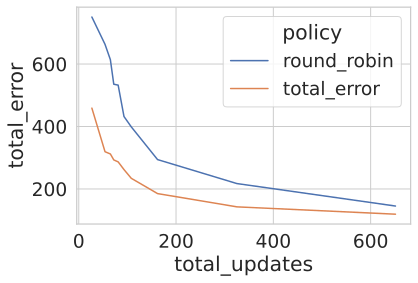

In [88]:
sns.lineplot(data=result_df, x="total_updates", y="total_error", hue="policy")

<AxesSubplot:xlabel='total_updates', ylabel='average_staleness'>

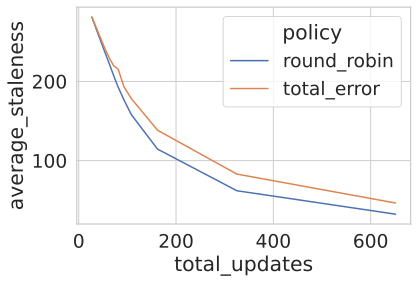

In [89]:
sns.lineplot(data=result_df, x="total_updates", y="average_staleness", hue="policy")

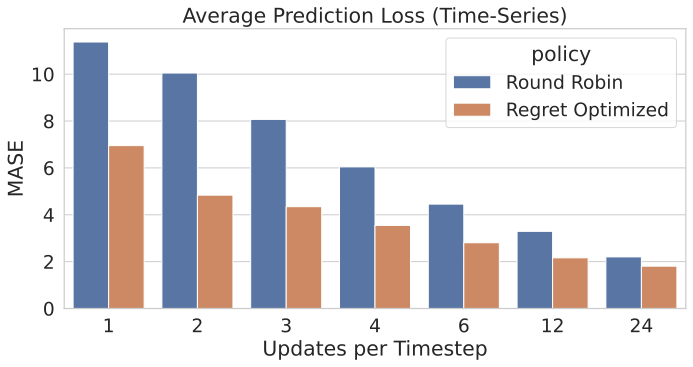

In [90]:
f, ax = plt.subplots(ncols=1, figsize=(10, 5))
plt.tight_layout()
sns.set_theme(style="whitegrid", font_scale=1.7)

sns.barplot(x="updates", y="average_error", hue="policy", data=plot_df, ax=ax)
ax.set(title="Average Prediction Loss (Time-Series)", xlabel="Updates per Timestep",  ylabel="MASE")
plt.savefig('/data/wooders/ralf-vldb/plots/stl_a1_error.pdf')

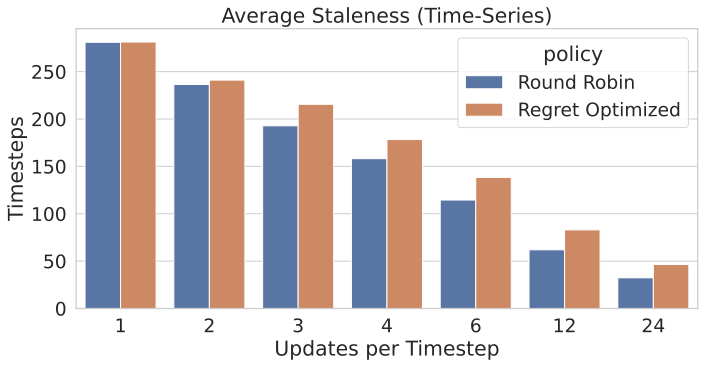

In [91]:
f, ax = plt.subplots(ncols=1, figsize=(10, 5))
plt.tight_layout()
sns.set_theme(style="whitegrid", font_scale=1.7)

sns.barplot(x="updates", y="average_staleness", hue="policy", data=plot_df)
ax.set(title="Average Staleness (Time-Series)", xlabel="Updates per Timestep",  ylabel="Timesteps")
plt.savefig('/data/wooders/ralf-vldb/plots/stl_a1s_staleness.pdf')

In [98]:
heat_df = plot_df.pivot("policy", "user_id", "updates").sort_values("Round Robin", axis=1, ascending=False).fillna(0)
f, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(
    heat_df.iloc[:, :20], 
    annot=True, 
    cbar=False,  
    #yticklabels=["Regret\nOptimized", "Round\nRobin"],
    xticklabels=range(1, 21, 1),
    square=True,
    ax=ax
)
ax.set_xlabel(f"Most Updated Users (Timestamps {ts_min}-{ts_max})")
ax.set_ylabel(None)
ax.set_title("Number of Featurization Updates")

KeyError: 'user_id'

In [92]:
updates_df = pd.concat([
    pd.read_csv(f"{result_dir}/{p}_{r}_A1/simulation_update_time.csv")
    for r in runtime for p in policy
])
updates_df

,Unnamed: 0,runtime,policy,key,i,time
0,0,24,round_robin,1,0,72
1,1,24,round_robin,2,0,96
2,2,24,round_robin,3,0,120
3,3,24,round_robin,4,0,144
4,4,24,round_robin,5,0,168
...,...,...,...,...,...,...
646,646,1,total_error,47,0,198
647,647,1,total_error,47,1,347
648,648,1,total_error,47,2,434
649,649,1,total_error,47,3,511


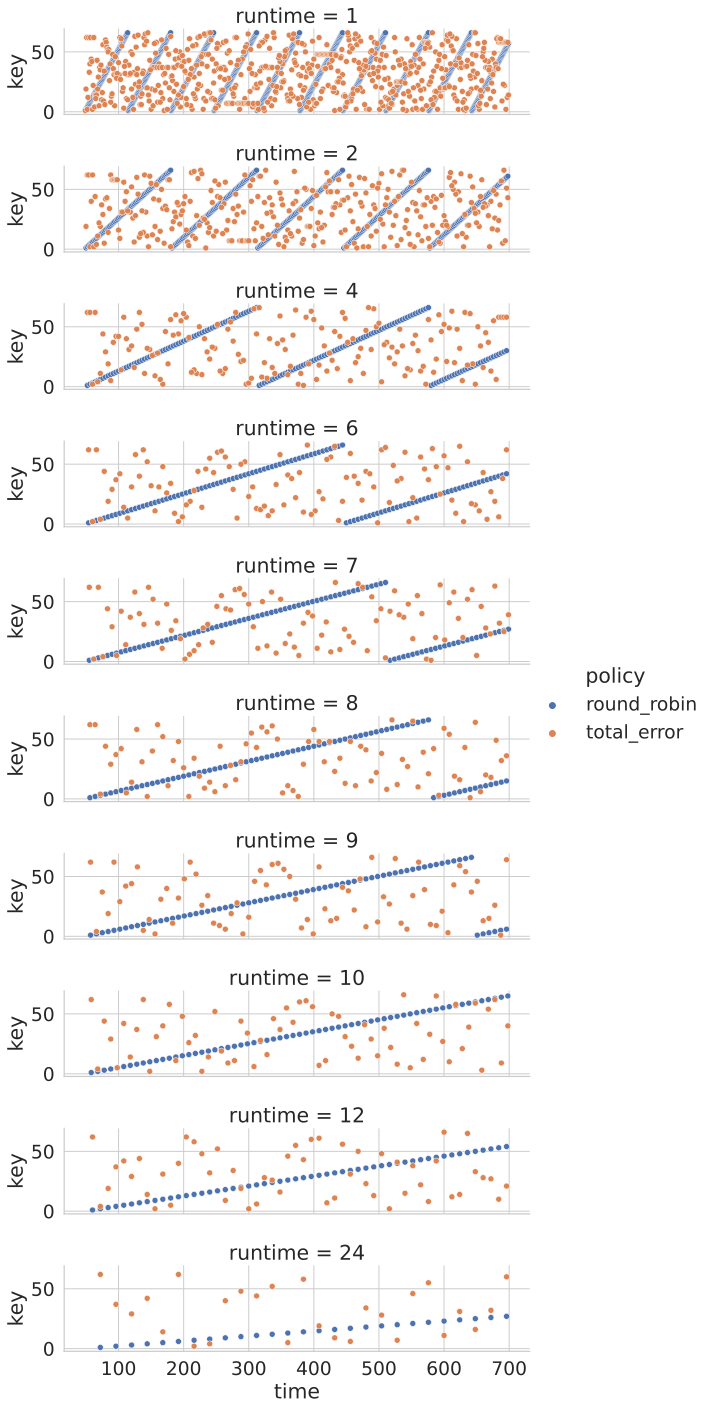

In [93]:
with sns.axes_style("whitegrid"):
    sns.relplot(data=updates_df, x="time", y="key", hue="policy", col="runtime", col_wrap=1, height=2, aspect=4)

In [94]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()

d = updates_df[(updates_df["key"] < 20)].groupby(["key", "runtime", "policy"]).size().unstack("key", fill_value=0)
d

key                  1   2   3   4   5   6   7   8   9   10  11  12  13  14  \
runtime policy                                                                
1       round_robin  10  10  10  10  10  10  10  10  10  10  10  10  10  10   
        total_error   6  25   6   7  10  10  21   9   9   9  18   7  10   9   
2       round_robin   5   5   5   5   5   5   5   5   5   5   5   5   5   5   
        total_error   2  13   3   3   6   4  13   3   4   4   9   3   5   5   
4       round_robin   3   3   3   3   3   3   3   3   3   3   3   3   3   3   
        total_error   1   6   1   2   3   3   2   1   2   2   7   2   4   3   
6       round_robin   2   2   2   2   2   2   2   2   2   2   2   2   2   2   
        total_error   1   4   1   2   3   2   1   1   2   1   4   1   1   2   
7       round_robin   2   2   2   2   2   2   2   2   2   2   2   2   2   2   
        total_error   1   3   1   1   3   1   1   1   2   1   3   1   1   2   
8       round_robin   2   2   2   2   2   2   2   2   2   2   2   2   2   2   
        total_error   1   3   1   1   2   2   1   1   1   1   4   1   1   2   
9       round_robin   2   2   2   2   2   2   1   1   1   1   1   1   1   1   
        total_error   1   3   1   1   1   2   1   1   2   1   3   1   2   2   
10      round_robin   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
        total_error   0   2   1   1   2   1   1   1   2   1   3   1   1   2   
12      round_robin   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
        total_error   0   3   0   1   1   1   1   1   1   1   1   1   1   2   
24      round_robin   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
        total_error   0   1   0   1   1   1   1   0   1   0   1   0   0   1   

key                  15  16  17  18  19  
runtime policy                           
1       round_robin  10  10  10  10  10  
        total_error   8   8  14   7  14  
2       round_robin   5   5   5   5   5  
        total_error   4   6   5   3  11  
4       round_robin   3   3   3   3   3  
        total_error   3   3   2   2   5  
6       round_robin   2   2   2   2   2  
        total_error   1   3   1   1   4  
7       round_robin   2   2   2   2   2  
        total_error   1   2   0   1   2  
8       round_robin   2   1   1   1   1  
        total_error   1   2   0   1   2  
9       round_robin   1   1   1   1   1  
        total_error   2   1   0   0   2  
10      round_robin   1   1   1   1   1  
        total_error   1   1   0   0   1  
12      round_robin   1   1   1   1   1  
        total_error   1   1   0   0   2  
24      round_robin   1   1   1   1   1  
        total_error   0   1   0   0   1

In [106]:
hist_df = updates_df[updates_df["runtime"] == 1].groupby(by=["policy", "key"]).time.count().reset_index()
hist_df["policy"] = hist_df["policy"].map({"round_robin": "Round Robin", "total_error": "Regret Optimized"})
hist_df

,policy,key,time
0,Round Robin,1,10
1,Round Robin,2,10
2,Round Robin,3,10
3,Round Robin,4,10
4,Round Robin,5,10
...,...,...,...
127,Regret Optimized,62,15
128,Regret Optimized,63,6
129,Regret Optimized,64,5
130,Regret Optimized,65,6


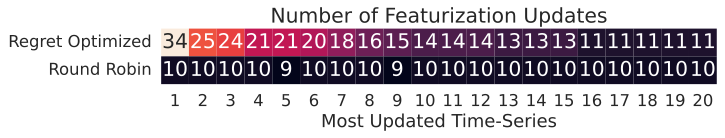

In [125]:
heat_df = hist_df.pivot("policy", "key", "time").sort_values("Regret Optimized", axis=1, ascending=False).fillna(0)
f, ax = plt.subplots(figsize=(10, 5))
#plt.tight_layout()
sns.set_theme(style="whitegrid", font_scale=1.7)

sns.heatmap(
    heat_df.iloc[:, :20],
    annot=True, 
    cbar=False,  
    #yticklabels=["Regret\nOptimized", "Maximum\nPending", "Minimum\nPast", "Round\nRobin"],
    xticklabels=range(1, 21, 1),
    square=True,
    ax=ax
)
ax.set_xlabel(f"Most Updated Time-Series")
ax.set_ylabel(None)
ax.set_title("Number of Featurization Updates")
#plt.legend(fontsize='x-large')
plt.savefig('/data/wooders/ralf-vldb/plots/stl_a1_heatmap.pdf', dpi=300, bbox_inches = "tight")

In [95]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

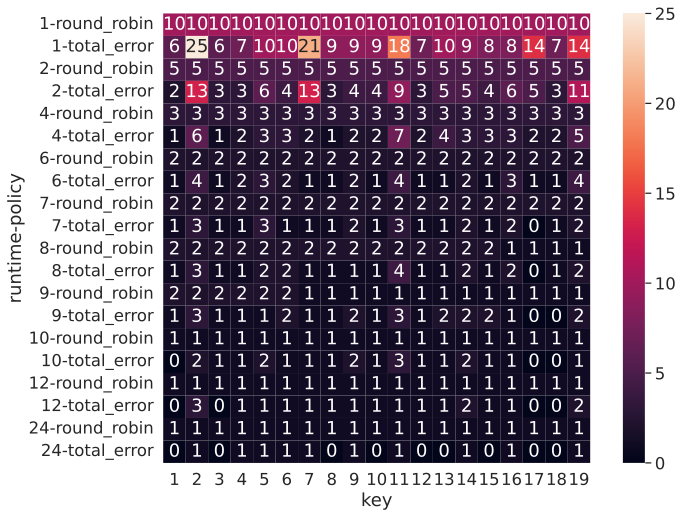

In [122]:
ax = sns.heatmap(d, square=True, annot=True)

In [97]:
r = 4
df_te = pd.read_csv(f"{result_dir}/total_error_{r}_A1/simulation_predictions.csv")
df_rr = pd.read_csv(f"{result_dir}/round_robin_{r}_A1/simulation_predictions.csv")

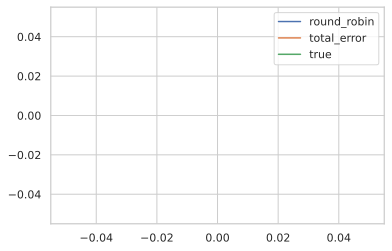

In [1876]:
key = 60

df_rr[df_rr["key"] == key].y_pred.plot(label="round_robin")
df_te[df_te["key"] == key].y_pred.plot(label="total_error")
df_te[df_te["key"] == key].y_true.plot(label="true").legend()

In [1822]:
print("round robin", error(df_rr[df_rr["key"] == key]))
print("total error", error(df_te[df_te["key"] == key]))

3 0.838575415975732
round robin 0.838575415975732
3 1.161520532043487
total error 1.161520532043487


<AxesSubplot:>

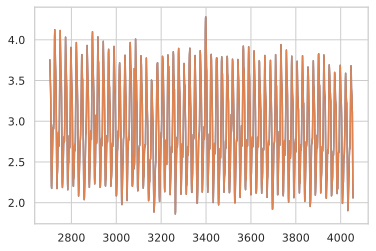

In [1823]:
df_te[df_te["key"] == key].y_true.plot()
df_rr[df_rr["key"] == key].y_true.plot()

In [1647]:
total = 0
for key in range(1, 15, 1): 
    e = mean_absolute_scaled_error(np.array(predictions[key]), np.array(values[key]), y_train=np.array(values[key]))
    total += e
    print(key, e)
print(total)

1 1.3134427563041695
2 7.293551441578921
3 0.2758726852546551
4 0.9261573832917106
5 1.6592285177648323
6 2.0306377203667365
7 2.245768410476465
8 1.4916199364242508
9 0.7738320531079034
10 1.3006956529401725
11 2.927519294147988
12 1.1125191766192482
13 0.6645589414694003
14 1.399706553740154
25.415110523486607


In [1752]:
df_all

,y_pred,y_true,staleness,key
0,0.032859,0.076970,0,1
1,0.093368,0.063933,1,1
2,0.072371,0.149733,2,1
3,0.085979,0.041479,3,1
4,0.089652,0.089318,4,1
...,...,...,...,...
1347,2215.541645,1639.000000,7,14
1348,1762.541643,719.000000,8,14
1349,2028.541640,725.000000,9,14
1350,2014.541638,787.000000,10,14


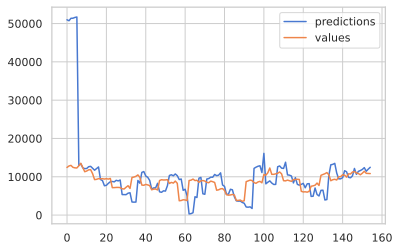

In [1638]:
key = 2
round_robin_df = pd.DataFrame({"predictions": predictions[key], "value": values[key]})
round_robin_df.predictions.plot(label="predictions")
round_robin_df.value.plot(label="values").legend()

# Train Model 

In [1496]:
from io import StringIO
def collect_data(arr, times, start, length=None, max_staleness=None):
    """
    
    :arr: data array for key  
    :update_times: list of timesteps to update for key 
    :start: starting point of eval
    """
    if not length: 
        length = len(arr) - start 
    if not max_staleness: 
        max_staleness = start + length
      
    times = sorted(times)
    
    # compute start model 
    chunk = arr[start - WINDOW_SIZE : start]
    last_model = STLForecast(
        chunk, ARIMA, model_kwargs=dict(order=(1, 1, 0), trend="t"), period=24
    ).fit()
    #print(pd.read_csv(StringIO(last_model.model_result.summary(alpha=0.05).tables[2].as_csv())))
    model_mse = last_model.model_result.mse
    model_hqic = last_model.model_result.hqic
    model_bic = last_model.model_result.bic
    model_aic = last_model.model_result.aic
    last_model = last_model.forecast(2000).tolist()
    last_time = start 
    
    
    errors = []
    features = []
    
    def collect_prediction_data(last_model, curr_model, curr_time): 
        total_error = 0
        for j in range(1, max_staleness): 
            y_true = arr[last_time: last_time + j]
            y_pred = np.array(last_model[:j])
            total_error += mean_absolute_scaled_error(y_true, y_pred, y_train=y_true, sp=1)
            
            y_true = arr[curr_time: curr_time + j]
            y_pred = np.array(curr_model[:j])
            c2 = mean_absolute_scaled_error(y_true, y_pred, y_train=y_true, sp=24))
            
            features.append([
                last_time + j, 
                j, 
                #arr[last_time + j - 1], 
                #arr[last_time], 
                model_mse, 
                model_hqic,
                model_bic,
                model_aic
            ])
        
    for i in range(len(times)):
        ts = times[i]
        assert ts <= start + length 
        chunk = arr[ts - WINDOW_SIZE : ts]
        # collect data 
        
        
        # train new model
        curr_model = STLForecast(
            chunk, ARIMA, model_kwargs=dict(order=(1, 1, 0), trend="t"), period=24, robust=True
        ).fit()
        collect_prediction_data(last_model, curr_model.forecast(2000))
        
        model_mse = last_model.model_result.mse
        model_hqic = last_model.model_result.hqic
        model_bic = last_model.model_result.bic
        model_aic = last_model.model_result.aic
        #print(last_model.summary())
        last_model = last_model.forecast(2000).tolist()
        last_time = ts
    

    return errors, features

In [1497]:
# def collect_data(arr, slide_size, start, length=None):
#     """
#     Compute single-key errors given a list of update timestamps 
    
#     :arr: data array for key  
#     :update_times: list of timesteps to update for key 
#     :start: starting point of eval
#     """
#     errors = []
#     if not start: 
#         start =  0 
#     if not length: 
#         length = len(arr)
      
#     n_fits = 0
#     update_times = sorted(update_times)
    
    
#     # compute start model 
#     chunk = arr[start - WINDOW_SIZE : start]
#     #print(start, WINDOW_SIZE, len(chunk))
#     last_model = STLForecast(
#         chunk, ARIMA, model_kwargs=dict(order=(1, 1, 0), trend="t"), period=24
#     ).fit().forecast(2000).tolist()
#     last_time = start 
    
#     error = [] 
#     staleness = []
#     for i in range(len(update_times)):
#         ts = update_times[i]
#         assert ts <= start + length 
#         #print("predict", ts, "last", last_time)
#         chunk = arr[ts - WINDOW_SIZE : ts]
        
#         # evaluate with last model 
#         y_pred += last_model[: ts - last_time]
#         staleness += []
        
#         # train new model
#         last_model = STLForecast(
#             chunk, ARIMA, model_kwargs=dict(order=(1, 1, 0), trend="t"), period=24
#         ).fit().forecast(2000).tolist()
#         last_time = ts
        

#     # fill in remaining predictions 
    
#     y_pred += last_model[: start + length - last_time]
       
#     y_true = arr[start : start + length]
#     if len(y_pred) != len(y_true): 
#         print("pred", len(y_pred), len(last_model[: length - last_time]), length - last_time, "true", len(y_true))
#         assert False 
#     error = mean_absolute_scaled_error(y_true, y_pred, y_train=y_true, sp=24)
#     return error 

In [1550]:
1400/WINDOW_SIZE

29.166666666666668

In [1551]:
train = []
test = []

train_start = WINDOW_SIZE
test_start = WINDOW_SIZE*13
length = WINDOW_SIZE*12
print(train_start, test_start, length)

for i in tqdm(range(1, 15)):
    df = remove_anomaly(pd.read_csv(f"{dataset_dir}/{i}.csv"))
    arr = df.value.values
    
    errors, features = collect_data(arr, [train_start, train_start + WINDOW_SIZE], train_start, length, max_staleness = WINDOW_SIZE*2)
    for e, f in zip(errors, features): 
        train.append({"key": i, "error": e, "features": f})
        
    errors, features = collect_data(arr, [test_start + WINDOW_SIZE], test_start, length, max_staleness = WINDOW_SIZE*2)
    for e, f in zip(errors, features): 
        test.append({"key": i, "error": e, "features": f})

  0%|          | 0/14 [00:00<?, ?it/s]

48 624 576


/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/

/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/

/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 64%|██████▍   | 9/14 [00:25<00:16,  3.23s/it]/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/data/wooders/anac

100%|██████████| 14/14 [00:36<00:00,  2.63s/it]


In [1499]:
WINDOW_SIZE*2

96

In [1552]:
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)

In [1553]:
test_df

,key,error,features
0,1,0.496749,"[649, 25, 0.0001730666792588623, -946.91502786..."
1,1,0.739819,"[650, 26, 0.0001730666792588623, -946.91502786..."
2,1,1.003709,"[651, 27, 0.0001730666792588623, -946.91502786..."
3,1,1.204328,"[652, 28, 0.0001730666792588623, -946.91502786..."
4,1,1.178619,"[653, 29, 0.0001730666792588623, -946.91502786..."
...,...,...,...
1983,14,1.737861,"[763, 91, 8883.523428730996, 433.6213482168982..."
1984,14,1.751720,"[764, 92, 8883.523428730996, 433.6213482168982..."
1985,14,1.765789,"[765, 93, 8883.523428730996, 433.6213482168982..."
1986,14,1.787923,"[766, 94, 8883.523428730996, 433.6213482168982..."


In [1554]:
train_df[train_df["key"] == 8]

,key,error,features
1491,8,5.876671,"[73, 25, 99.28236370573906, -946.9000726774404..."
1492,8,6.615388,"[74, 26, 99.28236370573906, -946.9000726774404..."
1493,8,6.138051,"[75, 27, 99.28236370573906, -946.9000726774404..."
1494,8,5.185189,"[76, 28, 99.28236370573906, -946.9000726774404..."
1495,8,2.317641,"[77, 29, 99.28236370573906, -946.9000726774404..."
...,...,...,...
1699,8,1.113463,"[187, 91, 162.06151829804773, 370.168977966410..."
1700,8,1.121924,"[188, 92, 162.06151829804773, 370.168977966410..."
1701,8,1.133813,"[189, 93, 162.06151829804773, 370.168977966410..."
1702,8,1.146495,"[190, 94, 162.06151829804773, 370.168977966410..."


In [1555]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle

In [1575]:
models = {}

for key in train_df.groupby("key").groups.keys(): 
    x_train = np.array(train_df[train_df["key"] == key].features.to_list())[:, 1:]
    y_train = train_df[train_df["key"] == key].error.tolist()
    
    x_train, y_train = shuffle(x_train, y_train)
    
    x_test = np.array(test_df[test_df["key"] == key].features.tolist())[:, 1:]
    y_test = test_df[test_df["key"] == key].error.tolist()
    
    
    x_test, y_test = shuffle(x_test, y_test)
    
    #clf = LinearRegression().fit([[x] for x in x_train], y_train)
    clf = RandomForestRegressor(random_state=0)
    clf.fit(x_train, y_train)

    y_pred = clf.predict(x_test)
    error = mean_squared_error(y_pred, y_test)
    print(key, error)
    models[key] = {"error": error, "model": clf, "x": x_train, "y": y_train}

1 0.23966660034455975
2 17.036282159484735
3 9.954298283693017
4 3.4072612084537197
5 1.3599743721291393
6 1.385559925671402
7 1.6035004366123375e+30
8 1.7405578753464361
9 23.63425433422731
10 0.7955033586944598
11 0.9780394962270911
12 0.7635670275958596
13 40.24969588209499
14 0.5485704006857423


In [1574]:
single_model = RandomForestRegressor(random_state=0)

x_train = np.array(train_df.features.to_list())
x_train[:, 0] = train_df.key.to_numpy()
y_train = train_df.error.to_numpy()
x_train, y_train = shuffle(x_train, y_train)

x_test = np.array(test_df.features.to_list())
x_test[:, 0] = test_df.key.to_numpy()
y_test = test_df.error.to_numpy()
x_test, y_test = shuffle(x_test, y_test)

single_model.fit(x_train, y_train)

y_pred = single_model.predict(x_test)
error = mean_squared_error(y_pred, y_test)
print(error)

1.1453574547230978e+29


In [1557]:
np.array([v["error"] for v in models.values()]).mean()

1.1453574547230982e+29

In [1558]:
np.array([v["error"] for v in models.values()]).mean()

1.1453574547230982e+29

<AxesSubplot:xlabel='timestamps'>

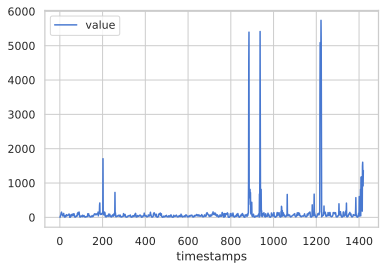

In [1559]:
key = 8
df = pd.read_csv(f"{dataset_dir}/{key}.csv")
df.plot(y="value", x="timestamps")


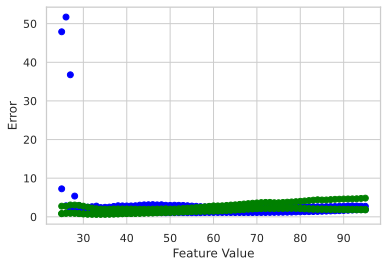

In [1562]:
import matplotlib.pyplot as plt

# plot single key 

key = 13
x_plot = np.array(test_df[test_df["key"] == key].features.to_list())[:, 1]
y_plot = test_df[test_df["key"] == key].error.tolist()
plt.scatter(
    x_plot, 
    y_plot, 
    c ="blue"
)


plt.scatter(
    np.array(train_df[train_df["key"] == key].features.to_list())[:, 1], 
    train_df[train_df["key"] == key].error.tolist(), 
    c ="green"
)

plt.ylabel("Error")
plt.xlabel("Feature Value")
plt.show()

In [1563]:
test_df[test_df["key"] == key].error

1704    7.247284
1705    2.844095
1706    1.921835
1707    1.640297
1708    1.293640
          ...   
1841    2.824464
1842    2.840782
1843    2.807595
1844    2.766747
1845    2.732025
Name: error, Length: 142, dtype: float64

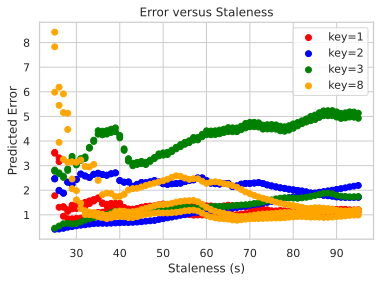

In [1566]:
import matplotlib.pyplot as plt

# compare multiple keys 

key = 1 
plt.scatter(models[key]["x"][:,0], models[key]["model"].predict(models[key]["x"]), c ="red", label=f"key={key}")

key = 2 
plt.scatter(models[key]["x"][:,0], models[key]["model"].predict(models[key]["x"]), c ="blue", label=f"key={key}")

key = 3 
plt.scatter(models[key]["x"][:,0], models[key]["model"].predict(models[key]["x"]), c ="green", label=f"key={key}")

key = 8 
plt.scatter(models[key]["x"][:,0], models[key]["model"].predict(models[key]["x"]), c ="orange", label=f"key={key}")
 

plt.legend()
# To show the plot
plt.title("Error versus Staleness")
plt.ylabel("Predicted Error")
plt.xlabel("Staleness (s)")
plt.show()

In [1517]:
models[key]["model"]

RandomForestRegressor(random_state=0)

# Simulate Policy (streaming, choose key)

In [1567]:
runtime = 12

In [1568]:
data = {}
for i in tqdm(range(1, 15)):
    df = remove_anomaly(pd.read_csv(f"{dataset_dir}/{i}.csv"))
    arr = df.value.values 
    data[i] = arr 

  0%|          | 0/14 [00:00<?, ?it/s]/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  7%|▋         | 1/14 [00:00<00:07,  1.70it/s]/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/

/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 79%|███████▊  | 11/14 [00:31<00:09,  3.07s/it]/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/data/wooders/ana

In [1576]:
# read keys 
# 

staleness = {key: 0 for key in range(1, 15, 1)}

update_times = defaultdict(list)

def get_model(key, ts): 

    chunk = data[key][ts - WINDOW_SIZE : ts]
    last_model = STLForecast(
        chunk, ARIMA, model_kwargs=dict(order=(1, 1, 0), trend="t"), period=24
    ).fit()
    print("new model", key, ts, last_model.model_result.mse)
    return last_model

last_model = {key: get_model(key, test_start) for key in range(1, 15, 1)} 

for ts in range(test_start+runtime, 1400, runtime):
    
    # update key staleness 
    for key in staleness.keys():
        staleness[key] += runtime
    
    # predict loss 
    #scores = clf.predict([[x] for x in staleness])
    features = [[
        staleness[i], 
        last_model[i].model_result.mse,
        last_model[i].model_result.hqic,
        last_model[i].model_result.bic,
        last_model[i].model_result.aic,
    ] for i in range(1, 15, 1)]
    scores = [models[i]["model"].predict([features[i-1]]) for i in range(1, 15, 1)]
    scores[7] = -10000000
    print(scores)
    for i in range(1, 15, 1): 
        if staleness[i] > WINDOW_SIZE*3: 
            scores[i - 1] = 1000000
    print(staleness)
    #print(scores)
    
    key = np.array(scores).argmax() + 1
    print(key, scores[key-1])
    print(features[key-1])
    print(models[key]["model"].predict([features[key-1]]))
    print()
    
    # mark as update time for key 
    update_times[key].append(ts)
    staleness[key] = 0 
    last_model[key] = get_model(key, ts)

/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


new model 1 624 0.0001730666792588623
new model 2 624 2359417.774006842
new model 3 624 0.17644284763958115
new model 4 624 99.99774169921868


/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


new model 5 624 219223.43810919556
new model 6 624 470.2920734612028


/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


new model 7 624 1.8026835444818812
new model 8 624 25.723784755272657
new model 9 624 2.1255032480904385e-05


/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


new model 10 624 1.689420524645066
new model 11 624 131945.68062088557
new model 12 624 28.267137394046852
new model 13 624 3332847.72969956


/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


new model 14 624 8209.974614721019
[array([3.70161345]), array([2.46276124]), array([2.81770475]), array([3.79227158]), array([1.0413108]), array([0.90810417]), array([3.63089867]), -10000000, array([1.37056813]), array([1.68911364]), array([4.94023945]), array([0.95058255]), array([0.82834369]), array([4.54696182])]
{1: 12, 2: 12, 3: 12, 4: 12, 5: 12, 6: 12, 7: 12, 8: 12, 9: 12, 10: 12, 11: 12, 12: 12, 13: 12, 14: 12}
11 [4.94023945]
[12, 131945.68062088557, -973.9764097588286, -970.5146358677264, -976.0650786728565]
[4.94023945]

new model 11 636 168641.5740990461
[array([3.70161345]), array([2.46276124]), array([2.81770475]), array([3.79227158]), array([1.0413108]), array([0.90810417]), array([3.63089867]), -10000000, array([1.37056813]), array([1.68911364]), array([4.94023945]), array([0.95058255]), array([0.82834369]), array([4.54696182])]
{1: 24, 2: 24, 3: 24, 4: 24, 5: 24, 6: 24, 7: 24, 8: 24, 9: 24, 10: 24, 11: 12, 12: 24, 13: 24, 14: 24}
11 [4.94023945]
[12, 168641.5740990461,

<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


new model 11 648 194214.44099485732
[array([1.49247508]), array([2.64590068]), array([4.38744652]), array([3.22157092]), array([2.11901935]), array([1.87084818]), array([0.62447875]), -10000000, array([1.57931498]), array([2.28558365]), array([4.94023945]), array([1.13874785]), array([0.69031526]), array([2.79900225])]
{1: 36, 2: 36, 3: 36, 4: 36, 5: 36, 6: 36, 7: 36, 8: 36, 9: 36, 10: 36, 11: 12, 12: 36, 13: 36, 14: 36}
11 [4.94023945]
[12, 194214.44099485732, -946.8912750594905, -943.4295011683881, -948.9799439735183]
[4.94023945]



<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


new model 11 660 131694.57478638133
[array([1.12059779]), array([2.38638044]), array([3.33186424]), array([2.4027042]), array([2.16758397]), array([2.41545603]), array([0.83506617]), -10000000, array([2.32181273]), array([1.66546039]), array([4.94023945]), array([1.19257936]), array([1.08133498]), array([2.16288262])]
{1: 48, 2: 48, 3: 48, 4: 48, 5: 48, 6: 48, 7: 48, 8: 48, 9: 48, 10: 48, 11: 12, 12: 48, 13: 48, 14: 48}
11 [4.94023945]
[12, 131694.57478638133, -973.0189423987513, -969.5571685076491, -975.1076113127792]
[4.94023945]

new model 11 672 175589.29105688017


<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


[array([1.04285029]), array([2.38338601]), array([4.38858749]), array([3.04299213]), array([2.53637686]), array([2.20096427]), array([0.86796714]), -10000000, array([2.80649271]), array([1.65489165]), array([4.94023945]), array([1.19841137]), array([1.48522244]), array([2.19319634])]
{1: 60, 2: 60, 3: 60, 4: 60, 5: 60, 6: 60, 7: 60, 8: 60, 9: 60, 10: 60, 11: 12, 12: 60, 13: 60, 14: 60}
11 [4.94023945]
[12, 175589.29105688017, -928.3979387030577, -924.9361648119553, -930.4866076170855]
[4.94023945]

new model 11 684 223253.45817771318
[array([1.03474562]), array([2.30752537]), array([4.7392142]), array([2.78864458]), array([2.48218175]), array([2.3190467]), array([0.9474042]), -10000000, array([3.17872217]), array([1.66644441]), array([4.94023945]), array([1.31135918]), array([2.13725122]), array([2.20077713])]
{1: 72, 2: 72, 3: 72, 4: 72, 5: 72, 6: 72, 7: 72, 8: 72, 9: 72, 10: 72, 11: 12, 12: 72, 13: 72, 14: 72}
11 [4.94023945]
[12, 223253.45817771318, -946.8939679677098, -943.43219407

<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1
<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


new model 3 708 0.17973721114299276
[array([1.12980788]), array([1.71386619]), array([2.81770475]), array([3.48095932]), array([3.17512919]), array([2.90792412]), array([0.97400001]), -10000000, array([4.03999238]), array([1.5965638]), array([4.94023945]), array([1.45672677]), array([1.7976967]), array([3.1903951])]
{1: 96, 2: 96, 3: 12, 4: 96, 5: 96, 6: 96, 7: 96, 8: 96, 9: 96, 10: 96, 11: 24, 12: 96, 13: 96, 14: 96}
11 [4.94023945]
[24, 130056.82974439405, -971.84561987438, -968.3838459832778, -973.9342887884079]
[4.94023945]

new model 11 720 297488.27200546325


<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1
<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


[array([1.12980788]), array([1.71386619]), array([2.81770475]), array([3.48095932]), array([3.17512919]), array([2.90792412]), array([0.97400001]), -10000000, array([4.03999238]), array([1.5965638]), array([4.94023945]), array([1.45672677]), array([1.7976967]), array([3.1903951])]
{1: 108, 2: 108, 3: 24, 4: 108, 5: 108, 6: 108, 7: 108, 8: 108, 9: 108, 10: 108, 11: 12, 12: 108, 13: 108, 14: 108}
11 [4.94023945]
[12, 297488.27200546325, -971.8850820050998, -968.4233081139976, -973.9737509191277]
[4.94023945]

new model 11 732 489967.18464332185
[array([1.12980788]), array([1.71386619]), array([4.38744652]), array([3.48095932]), array([3.17512919]), array([2.90792412]), array([0.97400001]), -10000000, array([4.03999238]), array([1.5965638]), array([4.94023945]), array([1.45672677]), array([1.7976967]), array([3.1903951])]
{1: 120, 2: 120, 3: 36, 4: 120, 5: 120, 6: 120, 7: 120, 8: 120, 9: 120, 10: 120, 11: 12, 12: 120, 13: 120, 14: 120}
11 [4.94023945]
[12, 489967.18464332185, -973.8740120

/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


[4.94023945]

new model 11 744 586353.6997973078
[array([1.12980788]), array([1.71386619]), array([3.33186424]), array([3.48095932]), array([3.17512919]), array([2.90792412]), array([0.97400001]), -10000000, array([4.03999238]), array([1.5965638]), array([4.94023945]), array([1.45672677]), array([1.7976967]), array([3.1903951])]
{1: 132, 2: 132, 3: 48, 4: 132, 5: 132, 6: 132, 7: 132, 8: 132, 9: 132, 10: 132, 11: 12, 12: 132, 13: 132, 14: 132}
11 [4.94023945]
[12, 586353.6997973078, -969.9079198731072, -966.4461459820049, -971.996588787135]
[4.94023945]



<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


new model 11 756 408162.4303901832
[array([1.12980788]), array([1.71386619]), array([4.38858749]), array([3.48095932]), array([3.17512919]), array([2.90792412]), array([0.97400001]), -10000000, array([4.03999238]), array([1.5965638]), array([4.94023945]), array([1.45672677]), array([1.7976967]), array([3.1903951])]
{1: 144, 2: 144, 3: 60, 4: 144, 5: 144, 6: 144, 7: 144, 8: 144, 9: 144, 10: 144, 11: 12, 12: 144, 13: 144, 14: 144}
11 [4.94023945]
[12, 408162.4303901832, -947.5332594394981, -944.0714855483959, -949.6219283535261]
[4.94023945]

new model 11 768 319902.55360936536
[array([1.12980788]), array([1.71386619]), array([4.7392142]), array([3.48095932]), array([3.17512919]), array([2.90792412]), array([0.97400001]), -10000000, array([4.03999238]), array([1.5965638]), array([4.94023945]), array([1.45672677]), array([1.7976967]), array([3.1903951])]
{1: 156, 2: 156, 3: 72, 4: 156, 5: 156, 6: 156, 7: 156, 8: 156, 9: 156, 10: 156, 11: 12, 12: 156, 13: 156, 14: 156}
1 1000000
[156, 0.00

<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


[array([3.70161345]), array([1.71386619]), array([5.00248423]), array([3.48095932]), array([3.17512919]), array([2.90792412]), array([0.97400001]), -10000000, array([4.03999238]), array([1.5965638]), array([4.94023945]), array([1.45672677]), array([1.7976967]), array([3.1903951])]
{1: 12, 2: 168, 3: 84, 4: 168, 5: 168, 6: 168, 7: 168, 8: 168, 9: 168, 10: 168, 11: 24, 12: 168, 13: 168, 14: 168}
2 1000000
[168, 2359417.774006842, -949.740464968691, -946.2786910775887, -951.8291338827189]
[1.71386619]

new model 2 792 1116348.1866970144
[array([3.70161345]), array([2.47685916]), array([5.12739692]), array([3.48095932]), array([3.17512919]), array([2.90792412]), array([0.97400001]), -10000000, array([4.03999238]), array([1.5965638]), array([1.46342524]), array([1.45672677]), array([1.7976967]), array([3.1903951])]
{1: 24, 2: 12, 3: 96, 4: 180, 5: 180, 6: 180, 7: 180, 8: 180, 9: 180, 10: 180, 11: 36, 12: 180, 13: 180, 14: 180}
4 1000000
[180, 99.99774169921868, -762.7725022050688, -759.3107

<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1
<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


new model 4 804 46.508306697275025
[array([1.49247508]), array([2.47685916]), array([5.12739692]), array([3.79227158]), array([3.17512919]), array([2.90792412]), array([0.97400001]), -10000000, array([4.03999238]), array([1.5965638]), array([1.45083486]), array([1.45672677]), array([1.7976967]), array([3.1903951])]
{1: 36, 2: 24, 3: 108, 4: 12, 5: 192, 6: 192, 7: 192, 8: 192, 9: 192, 10: 192, 11: 48, 12: 192, 13: 192, 14: 192}
5 1000000
[192, 219223.43810919556, -946.9667396088382, -943.504965717736, -949.0554085228662]
[3.17512919]

new model 5 816 47381.24243851375
[array([1.12059779]), array([2.64087679]), array([5.12739692]), array([3.79227158]), array([0.96081611]), array([2.90792412]), array([0.97400001]), -10000000, array([4.03999238]), array([1.5965638]), array([1.55567815]), array([1.45672677]), array([1.7976967]), array([3.1903951])]
{1: 48, 2: 36, 3: 120, 4: 24, 5: 12, 6: 204, 7: 204, 8: 204, 9: 204, 10: 204, 11: 60, 12: 204, 13: 204, 14: 204}
6 1000000
[204, 470.29207346120

<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


new model 6 828 96.76669348640415
[array([1.04285029]), array([2.3853371]), array([5.12739692]), array([3.22157092]), array([0.96081611]), array([0.98440156]), array([0.97400001]), -10000000, array([4.03999238]), array([1.5965638]), array([1.75203541]), array([1.45672677]), array([1.7976967]), array([3.1903951])]
{1: 60, 2: 48, 3: 132, 4: 36, 5: 24, 6: 12, 7: 216, 8: 216, 9: 216, 10: 216, 11: 72, 12: 216, 13: 216, 14: 216}
7 1000000
[216, 1.8026835444818812, -973.997348507766, -970.5355746166638, -976.0860174217939]
[0.97400001]

new model 7 840 3.8380013925057845


<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


[array([1.03474562]), array([2.38209822]), array([5.12739692]), array([2.4027042]), array([1.55494861]), array([0.98440156]), array([3.63089867]), -10000000, array([4.03999238]), array([1.5965638]), array([1.79708491]), array([1.45672677]), array([1.7976967]), array([3.1903951])]
{1: 72, 2: 60, 3: 144, 4: 48, 5: 36, 6: 24, 7: 12, 8: 228, 9: 228, 10: 228, 11: 84, 12: 228, 13: 228, 14: 228}
8 1000000
[228, 25.723784755272657, -946.8473395376141, -943.3855656465117, -948.9360084516419]
[1.20150326]

new model 8 852 38.83251544793978
[array([1.09353098]), array([2.30933153]), array([5.12739692]), array([3.04299213]), array([1.41125765]), array([1.85081548]), array([3.63089867]), -10000000, array([4.03999238]), array([1.5965638]), array([1.73464615]), array([1.45672677]), array([1.7976967]), array([3.1903951])]
{1: 84, 2: 72, 3: 156, 4: 60, 5: 48, 6: 36, 7: 24, 8: 12, 9: 240, 10: 240, 11: 96, 12: 240, 13: 240, 14: 240}
3 1000000
[156, 0.17973721114299276, -946.862708891116, -943.40093500001

<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


new model 3 864 0.17442301701738464
[array([1.12980788]), array([1.88806625]), array([2.81770475]), array([2.78864458]), array([1.90368613]), array([2.32344049]), array([0.62447875]), -10000000, array([4.03999238]), array([1.5965638]), array([1.73464615]), array([1.45672677]), array([1.7976967]), array([3.1903951])]
{1: 96, 2: 84, 3: 12, 4: 72, 5: 60, 6: 48, 7: 36, 8: 24, 9: 252, 10: 252, 11: 108, 12: 252, 13: 252, 14: 252}
9 1000000
[252, 2.1255032480904385e-05, -946.923815408561, -943.4620415174587, -949.0124843225889]
[4.03999238]



<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


new model 9 876 2.0708355190093635e-05
[array([1.12980788]), array([1.71392339]), array([2.81770475]), array([3.23335955]), array([2.02931431]), array([2.1259326]), array([0.83506617]), -10000000, array([1.37056813]), array([1.5965638]), array([1.73464615]), array([1.45672677]), array([1.7976967]), array([3.1903951])]
{1: 108, 2: 96, 3: 24, 4: 84, 5: 72, 6: 60, 7: 48, 8: 36, 9: 12, 10: 264, 11: 120, 12: 264, 13: 264, 14: 264}
10 1000000
[264, 1.689420524645066, -947.365991295999, -943.9042174048967, -949.4546602100269]
[1.5965638]

new model 10 888 1.8200372215064549


<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1
<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


[array([1.12980788]), array([1.71392339]), array([4.38744652]), array([3.48095932]), array([2.43625522]), array([2.18372579]), array([0.86796714]), -10000000, array([1.37056813]), array([1.5718122]), array([1.73464615]), array([1.45672677]), array([1.7976967]), array([3.1903951])]
{1: 120, 2: 108, 3: 36, 4: 96, 5: 84, 6: 72, 7: 60, 8: 48, 9: 24, 10: 12, 11: 132, 12: 276, 13: 276, 14: 276}
12 1000000
[276, 28.267137394046852, -973.6095474659353, -970.1477735748331, -975.6982163799632]
[1.45672677]

new model 12 900 17.320027264559688
[array([1.12980788]), array([1.71392339]), array([3.33186424]), array([3.48095932]), array([2.26841627]), array([2.40428514]), array([0.9474042]), -10000000, array([1.57931498]), array([1.5718122]), array([1.73464615]), array([0.95058255]), array([1.7976967]), array([3.1903951])]
{1: 132, 2: 120, 3: 48, 4: 108, 5: 96, 6: 84, 7: 72, 8: 60, 9: 36, 10: 24, 11: 144, 12: 12, 13: 288, 14: 288}
13 1000000
[288, 3332847.72969956, -973.7347388481539, -970.2729649570

/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


new model 13 912 2051585.9996182362
[array([1.12980788]), array([1.71392339]), array([4.38858749]), array([3.48095932]), array([2.26841627]), array([2.67539885]), array([0.9565448]), -10000000, array([2.32181273]), array([1.94284662]), array([1.73464615]), array([0.95058255]), array([2.79890019]), array([3.1903951])]
{1: 144, 2: 132, 3: 60, 4: 120, 5: 108, 6: 96, 7: 84, 8: 72, 9: 48, 10: 36, 11: 156, 12: 24, 13: 12, 14: 300}
11 1000000
[156, 319902.55360936536, -946.8514359363289, -943.3896620452266, -948.9401048503568]
[1.73464615]

new model 11 924 296718.7383250031


<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1
<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


[array([1.12980788]), array([1.71392339]), array([4.7392142]), array([3.48095932]), array([2.26841627]), array([2.67539885]), array([0.97400001]), -10000000, array([2.80649271]), array([1.50025099]), array([4.94023945]), array([1.13874785]), array([2.79890019]), array([3.1903951])]
{1: 156, 2: 144, 3: 72, 4: 132, 5: 120, 6: 108, 7: 96, 8: 84, 9: 60, 10: 48, 11: 12, 12: 36, 13: 24, 14: 312}
1 1000000
[156, 0.00011497800390559846, -945.8363030930034, -942.374529201901, -947.9249720070312]
[1.12980788]

new model 1 936 5.78502353263224e-05
[array([3.70161345]), array([1.71392339]), array([5.00248423]), array([3.48095932]), array([2.26841627]), array([2.67539885]), array([0.97400001]), -10000000, array([3.17872217]), array([1.51085274]), array([4.94023945]), array([1.19257936]), array([1.98064451]), array([3.1903951])]
{1: 12, 2: 156, 3: 84, 4: 144, 5: 132, 6: 120, 7: 108, 8: 96, 9: 72, 10: 60, 11: 24, 12: 48, 13: 36, 14: 324}
2 1000000
[156, 1116348.1866970144, -969.6912425513708, -966.22

<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1
<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


new model 2 948 471318.09011670767
[array([3.70161345]), array([2.47685916]), array([5.12739692]), array([3.48095932]), array([2.26841627]), array([2.67539885]), array([0.97400001]), -10000000, array([3.68034551]), array([1.55046915]), array([1.46342524]), array([1.19841137]), array([2.02900925]), array([3.1903951])]
{1: 24, 2: 12, 3: 96, 4: 156, 5: 144, 6: 132, 7: 120, 8: 108, 9: 84, 10: 72, 11: 36, 12: 60, 13: 48, 14: 336}
4 1000000
[156, 46.508306697275025, -973.9194178926166, -970.4576440015143, -976.0080868066444]
[3.48095932]

new model 4 960 157.53650570374577
[array([1.49247508]), array([2.47685916]), array([5.12739692]), array([3.79227158]), array([2.26841627]), array([2.67539885]), array([0.97400001]), -10000000, array([4.03999238]), array([1.65137796]), array([1.45083486]), array([1.31135918]), array([2.79370975]), array([3.1903951])]
{1: 36, 2: 24, 3: 108, 4: 12, 5: 156, 6: 144, 7: 132, 8: 120, 9: 96, 10: 84, 11: 48, 12: 72, 13: 60, 14: 348}
5 1000000
[156, 47381.2424385137

<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[array([1.12059779]), array([2.64087679]), array([5.12739692]), array([3.79227158]), array([0.96081611]), array([2.67539885]), array([0.97400001]), -10000000, array([4.03999238]), array([1.59175552]), array([1.55567815]), array([1.31722586]), array([3.7147757]), array([3.1903951])]
{1: 48, 2: 36, 3: 120, 4: 24, 5: 12, 6: 156, 7: 144, 8: 132, 9: 108, 10: 96, 11: 60, 12: 84, 13: 72, 14: 360}
6 1000000
[156, 96.76669348640415, -948.5178458812102, -945.0560719901079, -950.606514795238]
[2.67539885]



<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


new model 6 984 71.82683075625336
[array([1.04285029]), array([2.3853371]), array([5.12739692]), array([3.22157092]), array([0.96081611]), array([0.98440156]), array([0.97400001]), -10000000, array([4.03999238]), array([1.59175552]), array([1.75203541]), array([1.45672677]), array([4.38033229]), array([3.1903951])]
{1: 60, 2: 48, 3: 132, 4: 36, 5: 24, 6: 12, 7: 156, 8: 144, 9: 120, 10: 108, 11: 72, 12: 96, 13: 84, 14: 372}
7 1000000
[156, 3.8380013925057845, -951.6766902500194, -948.2149163589172, -953.7653591640474]
[0.97400001]

new model 7 996 4.591428414398583


<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


[array([1.03474562]), array([2.38209822]), array([5.12739692]), array([2.4027042]), array([1.55494861]), array([0.98440156]), array([3.63089867]), -10000000, array([4.03999238]), array([1.59175552]), array([1.79708491]), array([1.45672677]), array([4.79067099]), array([3.1903951])]
{1: 72, 2: 60, 3: 144, 4: 48, 5: 36, 6: 24, 7: 12, 8: 156, 9: 132, 10: 120, 11: 84, 12: 108, 13: 96, 14: 384}
8 1000000
[156, 38.83251544793978, -949.2094802564213, -945.747706365319, -951.2981491704492]
[1.20150326]

new model 8 1008 35.48802654312248
[array([1.09353098]), array([2.30933153]), array([5.12739692]), array([3.04299213]), array([1.41125765]), array([1.85081548]), array([3.63089867]), -10000000, array([4.03999238]), array([1.59175552]), array([1.73464615]), array([1.45672677]), array([4.79067099]), array([3.1903951])]
{1: 84, 2: 72, 3: 156, 4: 60, 5: 48, 6: 36, 7: 24, 8: 12, 9: 144, 10: 132, 11: 96, 12: 120, 13: 108, 14: 396}
3 1000000
[156, 0.17442301701738464, -946.7662574105125, -943.30448351

<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


new model 3 1020 0.1767086035989118
[array([1.12980788]), array([1.88806625]), array([2.81770475]), array([2.78864458]), array([1.90368613]), array([2.32344049]), array([0.62447875]), -10000000, array([4.03999238]), array([1.59175552]), array([1.73464615]), array([1.45672677]), array([4.79067099]), array([3.1903951])]
{1: 96, 2: 84, 3: 12, 4: 72, 5: 60, 6: 48, 7: 36, 8: 24, 9: 156, 10: 144, 11: 108, 12: 132, 13: 120, 14: 408}
9 1000000
[156, 2.0708355190093635e-05, -946.8839503625734, -943.4221764714712, -948.9726192766013]
[4.03999238]



/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


new model 9 1032 2.0540803150025266e-05
[array([1.12980788]), array([1.71392339]), array([2.81770475]), array([3.23335955]), array([2.02931431]), array([2.1259326]), array([0.83506617]), -10000000, array([1.37056813]), array([1.59175552]), array([1.73464615]), array([1.45672677]), array([4.79067099]), array([3.1903951])]
{1: 108, 2: 96, 3: 24, 4: 84, 5: 72, 6: 60, 7: 48, 8: 36, 9: 12, 10: 156, 11: 120, 12: 144, 13: 132, 14: 420}
10 1000000
[156, 1.8200372215064549, -972.3943382350303, -968.932564343928, -974.4830071490582]
[1.59175552]

new model 10 1044 1.7179054481718528
[array([1.12980788]), array([1.71392339]), array([4.38744652]), array([3.48095932]), array([2.43625522]), array([2.18372579]), array([0.86796714]), -10000000, array([1.37056813]), array([1.40644735]), array([1.73464615]), array([1.45672677]), array([4.79067099]), array([3.1903951])]
{1: 120, 2: 108, 3: 36, 4: 96, 5: 84, 6: 72, 7: 60, 8: 48, 9: 24, 10: 12, 11: 132, 12: 156, 13: 144, 14: 432}
12 1000000
[156, 17.320027

<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


[4.79067099]

new model 13 1068 1475238.2519989014
[array([1.12980788]), array([1.71392339]), array([4.38858749]), array([3.48095932]), array([2.26841627]), array([2.67539885]), array([0.9565448]), -10000000, array([2.32181273]), array([1.56525308]), array([1.73464615]), array([0.95058255]), array([2.79890019]), array([3.1903951])]
{1: 144, 2: 132, 3: 60, 4: 120, 5: 108, 6: 96, 7: 84, 8: 72, 9: 48, 10: 36, 11: 156, 12: 24, 13: 12, 14: 456}
11 1000000
[156, 296718.7383250031, -970.6030282617348, -967.1412543706325, -972.6916971757627]
[1.73464615]



/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


new model 11 1080 378915.2021349847
[array([1.12980788]), array([1.71392339]), array([4.7392142]), array([3.48095932]), array([2.26841627]), array([2.67539885]), array([0.97400001]), -10000000, array([2.80649271]), array([1.30381491]), array([4.94023945]), array([1.13874785]), array([2.79890019]), array([3.1903951])]
{1: 156, 2: 144, 3: 72, 4: 132, 5: 120, 6: 108, 7: 96, 8: 84, 9: 60, 10: 48, 11: 12, 12: 36, 13: 24, 14: 468}
1 1000000
[156, 5.78502353263224e-05, -971.52272022083, -968.0609463297278, -973.611389134858]
[1.12980788]



<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


new model 1 1092 0.00010842908393464769
[array([3.70161345]), array([1.71392339]), array([5.00248423]), array([3.48095932]), array([2.26841627]), array([2.67539885]), array([0.97400001]), -10000000, array([3.17872217]), array([1.32636328]), array([4.94023945]), array([1.19257936]), array([1.98064451]), array([3.1903951])]
{1: 12, 2: 156, 3: 84, 4: 144, 5: 132, 6: 120, 7: 108, 8: 96, 9: 72, 10: 60, 11: 24, 12: 48, 13: 36, 14: 480}
2 1000000
[156, 471318.09011670767, -973.5602049777328, -970.0984310866305, -975.6488738917607]
[1.71392339]



<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


new model 2 1104 28885.546943165595
[array([3.70161345]), array([2.47685916]), array([5.12739692]), array([3.48095932]), array([2.26841627]), array([2.67539885]), array([0.97400001]), -10000000, array([3.68034551]), array([1.41664818]), array([1.46342524]), array([1.19841137]), array([2.02900925]), array([3.1903951])]
{1: 24, 2: 12, 3: 96, 4: 156, 5: 144, 6: 132, 7: 120, 8: 108, 9: 84, 10: 72, 11: 36, 12: 60, 13: 48, 14: 492}
4 1000000
[156, 157.53650570374577, -970.2884485907482, -966.8266746996459, -972.377117504776]
[3.48095932]



<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


new model 4 1116 62.61964246382703
[array([1.49247508]), array([2.47685916]), array([5.12739692]), array([3.79227158]), array([2.26841627]), array([2.67539885]), array([0.97400001]), -10000000, array([4.03999238]), array([1.65539815]), array([1.45083486]), array([1.31135918]), array([2.79370975]), array([3.1903951])]
{1: 36, 2: 24, 3: 108, 4: 12, 5: 156, 6: 144, 7: 132, 8: 120, 9: 96, 10: 84, 11: 48, 12: 72, 13: 60, 14: 504}
5 1000000
[156, 69483.63408025629, -970.8143396036301, -967.3525657125277, -972.9030085176579]
[2.26841627]



<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


new model 5 1128 165596.26809009016
[array([1.12059779]), array([2.64087679]), array([5.12739692]), array([3.79227158]), array([0.96081611]), array([2.67539885]), array([0.97400001]), -10000000, array([4.03999238]), array([1.5871509]), array([1.55567815]), array([1.31722586]), array([3.7147757]), array([3.1903951])]
{1: 48, 2: 36, 3: 120, 4: 24, 5: 12, 6: 156, 7: 144, 8: 132, 9: 108, 10: 96, 11: 60, 12: 84, 13: 72, 14: 516}
6 1000000
[156, 71.82683075625336, -948.3917802529324, -944.9300063618301, -950.4804491669603]
[2.67539885]

new model 6 1140 116.31565726755046


<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1
<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


[array([1.04285029]), array([2.3853371]), array([5.12739692]), array([3.22157092]), array([0.96081611]), array([1.2927317]), array([0.97400001]), -10000000, array([4.03999238]), array([1.5871509]), array([1.75203541]), array([1.45672677]), array([4.38033229]), array([3.1903951])]
{1: 60, 2: 48, 3: 132, 4: 36, 5: 24, 6: 12, 7: 156, 8: 144, 9: 120, 10: 108, 11: 72, 12: 96, 13: 84, 14: 528}
7 1000000
[156, 4.591428414398583, -974.4497164581098, -970.9879425670075, -976.5383853721377]
[0.97400001]

new model 7 1152 2.2583025655893834
[array([1.03474562]), array([2.38209822]), array([5.12739692]), array([2.4027042]), array([1.55494861]), array([1.2927317]), array([3.63089867]), -10000000, array([4.03999238]), array([1.5871509]), array([1.79708491]), array([1.45672677]), array([4.79067099]), array([3.1903951])]
{1: 72, 2: 60, 3: 144, 4: 48, 5: 36, 6: 24, 7: 12, 8: 156, 9: 132, 10: 120, 11: 84, 12: 108, 13: 96, 14: 540}
8 1000000
[156, 35.48802654312248, -973.8250359815063, -970.3632620904041

<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


new model 8 1164 21.59804309591988
[array([1.09353098]), array([2.30933153]), array([5.12739692]), array([3.04299213]), array([1.41125765]), array([1.7960904]), array([3.63089867]), -10000000, array([4.03999238]), array([1.5871509]), array([1.73464615]), array([1.45672677]), array([4.79067099]), array([3.1903951])]
{1: 84, 2: 72, 3: 156, 4: 60, 5: 48, 6: 36, 7: 24, 8: 12, 9: 144, 10: 132, 11: 96, 12: 120, 13: 108, 14: 552}
3 1000000
[156, 0.1767086035989118, -845.4159787808242, -841.954204889722, -847.5046476948521]
[5.12739692]

new model 3 1176 0.171875430577855


/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


[array([1.12980788]), array([1.88806625]), array([2.81770475]), array([2.78864458]), array([1.90368613]), array([2.02494957]), array([0.62447875]), -10000000, array([4.03999238]), array([1.5871509]), array([1.73464615]), array([1.45672677]), array([4.79067099]), array([3.1903951])]
{1: 96, 2: 84, 3: 12, 4: 72, 5: 60, 6: 48, 7: 36, 8: 24, 9: 156, 10: 144, 11: 108, 12: 132, 13: 120, 14: 564}
9 1000000
[156, 2.0540803150025266e-05, -970.0051221299102, -966.5433482388079, -972.093791043938]
[4.03999238]

new model 9 1188 1.594610435096758e-05


/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


[array([1.12980788]), array([1.71392339]), array([2.81770475]), array([3.23335955]), array([2.02931431]), array([1.87301897]), array([0.83506617]), -10000000, array([1.37056813]), array([1.5871509]), array([1.73464615]), array([1.45672677]), array([4.79067099]), array([3.1903951])]
{1: 108, 2: 96, 3: 24, 4: 84, 5: 72, 6: 60, 7: 48, 8: 36, 9: 12, 10: 156, 11: 120, 12: 144, 13: 132, 14: 576}
10 1000000
[156, 1.7179054481718528, -986.835416397445, -983.3736425063428, -988.9240853114729]
[1.5871509]

new model 10 1200 1.7382207463326063


/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


[array([1.12980788]), array([1.71392339]), array([4.38744652]), array([3.48095932]), array([2.43625522]), array([1.72555308]), array([0.86796714]), -10000000, array([1.37056813]), array([1.40701931]), array([1.73464615]), array([1.45672677]), array([4.79067099]), array([3.1903951])]
{1: 120, 2: 108, 3: 36, 4: 96, 5: 84, 6: 72, 7: 60, 8: 48, 9: 24, 10: 12, 11: 132, 12: 156, 13: 144, 14: 588}
12 1000000
[156, 10.379901181084193, -974.1330488411961, -970.6712749500938, -976.221717755224]
[1.45672677]

new model 12 1212 13.6170633952985


/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


[array([1.12980788]), array([1.71392339]), array([3.33186424]), array([3.48095932]), array([2.26841627]), array([1.84185988]), array([0.9474042]), -10000000, array([1.57931498]), array([1.40701931]), array([1.73464615]), array([0.95058255]), array([4.79067099]), array([3.1903951])]
{1: 132, 2: 120, 3: 48, 4: 108, 5: 96, 6: 84, 7: 72, 8: 60, 9: 36, 10: 24, 11: 144, 12: 12, 13: 156, 14: 600}
13 1000000
[156, 1475238.2519989014, -928.4617439256542, -924.9999700345519, -930.550412839682]
[4.79067099]

new model 13 1224 1731499.9329035275
[array([1.12980788]), array([1.71392339]), array([4.38858749]), array([3.48095932]), array([2.26841627]), array([1.88761932]), array([0.9565448]), -10000000, array([2.32181273]), array([1.56323199]), array([1.73464615]), array([0.95058255]), array([2.79890019]), array([3.1903951])]
{1: 144, 2: 132, 3: 60, 4: 120, 5: 108, 6: 96, 7: 84, 8: 72, 9: 48, 10: 36, 11: 156, 12: 24, 13: 12, 14: 612}
11 1000000
[156, 378915.2021349847, -973.5452530805746, -970.083479

<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566:

new model 11 1236 945280.4607741685
[array([1.12980788]), array([1.71392339]), array([4.7392142]), array([3.48095932]), array([2.26841627]), array([1.88761932]), array([0.97400001]), -10000000, array([2.80649271]), array([1.3049972]), array([4.94023945]), array([1.13874785]), array([2.79890019]), array([3.1903951])]
{1: 156, 2: 144, 3: 72, 4: 132, 5: 120, 6: 108, 7: 96, 8: 84, 9: 60, 10: 48, 11: 12, 12: 36, 13: 24, 14: 624}
1 1000000
[156, 0.00010842908393464769, -946.8443645585223, -943.38259066742, -948.9330334725502]
[1.12980788]

new model 1 1248 0.0005449063917837354
[array([3.33950758]), array([1.71392339]), array([5.00248423]), array([3.48095932]), array([2.26841627]), array([1.88761932]), array([0.97400001]), -10000000, array([3.17872217]), array([1.3284776]), array([4.94023945]), array([1.19257936]), array([1.98064451]), array([3.1903951])]
{1: 12, 2: 156, 3: 84, 4: 144, 5: 132, 6: 120, 7: 108, 8: 96, 9: 72, 10: 60, 11: 24, 12: 48, 13: 36, 14: 636}
2 1000000
[156, 28885.546943

<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


new model 4 1272 71.1403905467026
[array([1.4143512]), array([2.46276124]), array([5.12739692]), array([3.79227158]), array([2.26841627]), array([1.88761932]), array([0.97400001]), -10000000, array([4.03999238]), array([1.65549001]), array([1.45083486]), array([1.31135918]), array([2.79370975]), array([3.1903951])]
{1: 36, 2: 24, 3: 108, 4: 12, 5: 156, 6: 144, 7: 132, 8: 120, 9: 96, 10: 84, 11: 48, 12: 72, 13: 60, 14: 660}
5 1000000
[156, 165596.26809009016, -949.3212106488031, -945.8594367577008, -951.409879562831]
[2.26841627]



<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


new model 5 1284 34488.791010828005
[array([1.18082273]), array([2.64590068]), array([5.12739692]), array([3.79227158]), array([0.96081611]), array([1.88761932]), array([0.97400001]), -10000000, array([4.03999238]), array([1.58702435]), array([1.55567815]), array([1.31722586]), array([3.7147757]), array([3.1903951])]
{1: 48, 2: 36, 3: 120, 4: 24, 5: 12, 6: 156, 7: 144, 8: 132, 9: 108, 10: 96, 11: 60, 12: 84, 13: 72, 14: 672}
6 1000000
[156, 116.31565726755046, -972.1969106514814, -968.7351367603791, -974.2855795655092]
[1.88761932]

new model 6 1296 236.14283626026486


<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


[array([1.12248907]), array([2.38638044]), array([5.12739692]), array([3.22157092]), array([0.96081611]), array([1.2927317]), array([0.97400001]), -10000000, array([4.03999238]), array([1.58702435]), array([1.75203541]), array([1.45672677]), array([4.38033229]), array([3.1903951])]
{1: 60, 2: 48, 3: 132, 4: 36, 5: 24, 6: 12, 7: 156, 8: 144, 9: 120, 10: 108, 11: 72, 12: 96, 13: 84, 14: 684}
7 1000000
[156, 2.2583025655893834, -971.5127663676963, -968.0509924765939, -973.6014352817241]
[0.97400001]

new model 7 1308 2.1548279006323128
[array([1.09693876]), array([2.38338601]), array([5.12739692]), array([2.4027042]), array([1.55494861]), array([1.2927317]), array([3.63089867]), -10000000, array([4.03999238]), array([1.58702435]), array([1.79708491]), array([1.45672677]), array([4.79067099]), array([3.1903951])]
{1: 72, 2: 60, 3: 144, 4: 48, 5: 36, 6: 24, 7: 12, 8: 156, 9: 132, 10: 120, 11: 84, 12: 108, 13: 96, 14: 696}
8 1000000
[156, 21.59804309591988, -975.1903221017699, -971.728548210

<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


new model 8 1320 146.30205494599468
[array([1.11483358]), array([2.30752537]), array([5.12739692]), array([3.04299213]), array([1.41125765]), array([1.7960904]), array([3.63089867]), -10000000, array([4.03999238]), array([1.58702435]), array([1.73464615]), array([1.45672677]), array([4.79067099]), array([3.1903951])]
{1: 84, 2: 72, 3: 156, 4: 60, 5: 48, 6: 36, 7: 24, 8: 12, 9: 144, 10: 132, 11: 96, 12: 120, 13: 108, 14: 708}
3 1000000
[156, 0.171875430577855, -972.3320248075802, -968.870250916478, -974.4206937216081]
[5.12739692]



<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


new model 3 1332 0.1739119374694853
[array([1.14606471]), array([1.8881409]), array([2.81770475]), array([2.78864458]), array([1.90368613]), array([2.02494957]), array([0.62447875]), -10000000, array([4.03999238]), array([1.58702435]), array([1.73464615]), array([1.45672677]), array([4.79067099]), array([3.1903951])]
{1: 96, 2: 84, 3: 12, 4: 72, 5: 60, 6: 48, 7: 36, 8: 24, 9: 156, 10: 144, 11: 108, 12: 132, 13: 120, 14: 720}
9 1000000
[156, 1.594610435096758e-05, -948.5525023008745, -945.0907284097723, -950.6411712149024]
[4.03999238]



<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


new model 9 1344 4.47155152730654e-05
[array([1.14606471]), array([1.71386619]), array([2.81770475]), array([3.23335955]), array([2.02931431]), array([1.87301897]), array([0.83506617]), -10000000, array([1.46640415]), array([1.58702435]), array([1.73464615]), array([1.45672677]), array([4.79067099]), array([3.1903951])]
{1: 108, 2: 96, 3: 24, 4: 84, 5: 72, 6: 60, 7: 48, 8: 36, 9: 12, 10: 156, 11: 120, 12: 144, 13: 132, 14: 732}
10 1000000
[156, 1.7382207463326063, -972.1306145266001, -968.6688406354979, -974.219283440628]
[1.58702435]



<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


new model 10 1356 1.6656375769176988
[array([1.14606471]), array([1.71386619]), array([4.38744652]), array([3.48095932]), array([2.43625522]), array([1.72555308]), array([0.86796714]), -10000000, array([1.46640415]), array([1.689111]), array([1.73464615]), array([1.45672677]), array([4.79067099]), array([3.1903951])]
{1: 120, 2: 108, 3: 36, 4: 96, 5: 84, 6: 72, 7: 60, 8: 48, 9: 24, 10: 12, 11: 132, 12: 156, 13: 144, 14: 744}
12 1000000
[156, 13.6170633952985, -946.971572424832, -943.5097985337297, -949.0602413388599]
[1.45672677]



<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


new model 12 1368 11.86841882947436
[array([1.14606471]), array([1.71386619]), array([3.33186424]), array([3.48095932]), array([2.26841627]), array([1.84185988]), array([0.9474042]), -10000000, array([1.56496585]), array([1.689111]), array([1.73464615]), array([0.95058255]), array([4.79067099]), array([3.1903951])]
{1: 132, 2: 120, 3: 48, 4: 108, 5: 96, 6: 84, 7: 72, 8: 60, 9: 36, 10: 24, 11: 144, 12: 12, 13: 156, 14: 756}
13 1000000
[156, 1731499.9329035275, -973.1110748077647, -969.6493009166624, -975.1997437217925]
[4.79067099]

new model 13 1380 1998879.3412129667
[array([1.14606471]), array([1.71386619]), array([4.38858749]), array([3.48095932]), array([2.26841627]), array([1.88761932]), array([0.9565448]), -10000000, array([2.40960695]), array([2.2865892]), array([1.73464615]), array([0.95058255]), array([2.79890019]), array([3.1903951])]
{1: 144, 2: 132, 3: 60, 4: 120, 5: 108, 6: 96, 7: 84, 8: 72, 9: 48, 10: 36, 11: 156, 12: 24, 13: 12, 14: 768}
11 1000000
[156, 945280.460774168

<ipython-input-1576-9f3ec082abda>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.array(scores).argmax() + 1


In [1578]:
total = 0
for key, value in update_times.items():
    print(key, len(value))
    total += len(value)
    
total

11 15
3 5
1 4
2 4
4 4
5 4
6 4
7 4
8 4
9 4
10 4
12 4
13 4


64

In [1460]:
baseline_updates = total / 15

In [1461]:
n_fits = int((1400 - 500)/(15*runtime))
n_fits

30

In [440]:
slide_size = int((1400 - 500)*15/total)
slide_size

67

In [1547]:
total_fits = [] 
total_error = []
length = WINDOW_SIZE*
for i in tqdm(range(1, 15)):
    df = pd.read_csv(f"{dataset_dir}/{i}.csv")
    arr = df.value.values[:1400] # make same length
    print(i, update_times[i])
    print(update_times[i])
    print(test_start, length)
    model_error = compute_policy_error(arr, update_times[i], test_start, length)
    baseline_error = compute_policy_error(arr, [], test_start, length)
    
    total_fits.append(len(update_times[i]))
    total_error.append(model_error)
    
    print(key, "baseline", baseline_error)
    print(key, "model", model_error, update_times[i]) 
    print()
   

  0%|          | 0/14 [00:00<?, ?it/s]/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1 [492, 648, 804, 960, 1116, 1272]
[492, 648, 804, 960, 1116, 1272]
336 288


  0%|          | 0/14 [00:00<?, ?it/s]


AssertionError: 

In [442]:
print(total_fits, total_error)

[3, 12, 8, 13, 52, 11, 21, 15, 14, 7, 12, 7, 13, 12] [1.451694948264098, 1.3720004960743448, 8.52361143116274, 1.0953736952620694, 1.6707570853665146, 2.317949139188171, 1.4066797493127428, 1.6250836269150077, 0.9294752291852855, 1.5532070942413132, 1.7967285882433872, 3.6322809491262653, 1.171494100030803, 2.083032984663316]


In [780]:
#start= WINDOW_SIZE*9
#length = WINDOW_SIZE*5


start= WINDOW_SIZE*10
length = WINDOW_SIZE*4
total = 90
 
static_fits = [] 
static_error = []
slide_size = int((length)*15/total)
print(slide_size)
for i in tqdm(range(1, 15)):
    df = pd.read_csv(f"{dataset_dir}/{i}.csv")
    arr = df.value.values[:1400] # make same length
    resid = get_residual(arr[start:start+length])
    slide_times = [ts for ts in range(start, start + length, slide_size)]
    
    y_pred, y_true = compute_policy_error(arr, slide_times, start, length)
    pred_resid = y_true - y_pred
    #error = mean_absolute_scaled_error(y_true, y_pred, y_train=y_true, sp=24)
    error = mean_absolute_scaled_error(resid, pred_resid, y_train=y_true, sp=24)
    
    static_fits.append(len(slide_times))
    static_error.append(error)
    
    
    print(i, error)

print(static_fits, static_error)

  0%|          | 0/14 [00:00<?, ?it/s]

64


  7%|▋         | 1/14 [00:00<00:10,  1.25it/s]

1 0.6592464565055061


 14%|█▍        | 2/14 [00:01<00:08,  1.35it/s]

2 1.9621902328227325


 21%|██▏       | 3/14 [00:02<00:08,  1.31it/s]

3 1.259507784704326


 29%|██▊       | 4/14 [00:03<00:07,  1.30it/s]

4 1.0867917522971087


 36%|███▌      | 5/14 [00:03<00:06,  1.32it/s]

5 1.1559400844434036


 43%|████▎     | 6/14 [00:04<00:06,  1.32it/s]

6 1.0653410956562743


 50%|█████     | 7/14 [00:05<00:05,  1.24it/s]

7 1.1002397455143458


 57%|█████▋    | 8/14 [00:06<00:04,  1.27it/s]

8 0.5009025016661949


 64%|██████▍   | 9/14 [00:07<00:04,  1.22it/s]

9 0.8055947656667


 71%|███████▏  | 10/14 [00:07<00:03,  1.24it/s]

10 0.8113739491060649


 79%|███████▊  | 11/14 [00:08<00:02,  1.26it/s]

11 0.95903712134092


 86%|████████▌ | 12/14 [00:09<00:01,  1.27it/s]

12 0.8324879773575183


 93%|█████████▎| 13/14 [00:10<00:00,  1.31it/s]

13 1.1615478159394628


100%|██████████| 14/14 [00:10<00:00,  1.29it/s]

14 0.808770407390838
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6] [0.6592464565055061, 1.9621902328227325, 1.259507784704326, 1.0867917522971087, 1.1559400844434036, 1.0653410956562743, 1.1002397455143458, 0.5009025016661949, 0.8055947656667, 0.8113739491060649, 0.95903712134092, 0.8324879773575183, 1.1615478159394628, 0.808770407390838]


In [781]:
print(sum(static_fits))
print(sum(static_error))

84
14.168971690411395


In [665]:
slide_size

96

In [565]:
len(static_fits)

14

In [444]:
results = pd.DataFrame({"static_error": static_error, "model_error": total_error})

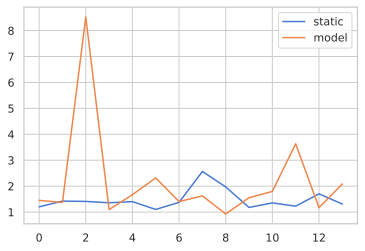

In [445]:
results["static_error"].plot(label="static")
results["model_error"].plot(label="model").legend()

In [446]:
results["static_error"].sum()

20.59226274883306

In [447]:
results["model_error"].sum()

30.629369117036052

  0%|          | 0/14 [00:00<?, ?it/s]

1 slide 96 10
1 [960, 1056, 1152, 1248] 960 384


  7%|▋         | 1/14 [00:00<00:08,  1.61it/s]

1 orig error 1.2384577139682613 960 384
1 1.0196367664339199
2 slide 48 20
2 [960, 1008, 1056, 1104, 1152, 1200, 1248, 1296] 960 384


 14%|█▍        | 2/14 [00:01<00:09,  1.25it/s]

2 orig error 2.1718082459192356 960 384
2 2.1517539773020693
3 slide 192 5
3 [960, 1152] 960 384


 21%|██▏       | 3/14 [00:01<00:06,  1.61it/s]

3 orig error 2.188686943343961 960 384
3 2.0681814291272964
4 slide 192 5
4 [960, 1152] 960 384
4 orig error 1.050548857108665 960 384


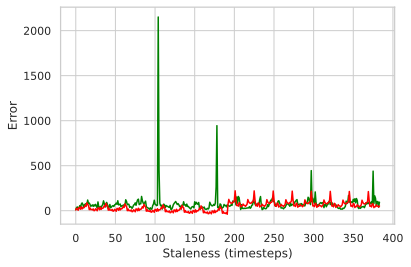

 29%|██▊       | 4/14 [00:02<00:05,  1.71it/s]

4 0.8391221027356924
5 slide 96 10
5 [960, 1056, 1152, 1248] 960 384


 36%|███▌      | 5/14 [00:03<00:05,  1.72it/s]

5 orig error 2.3384702010324414 960 384
5 2.1835052044180583
6 slide 96 10
6 [960, 1056, 1152, 1248] 960 384


 43%|████▎     | 6/14 [00:03<00:04,  1.73it/s]

6 orig error 1.5276074507737574 960 384
6 1.4541504656763706
7 slide 24 40
7 [960, 984, 1008, 1032, 1056, 1080, 1104, 1128, 1152, 1176, 1200, 1224, 1248, 1272, 1296, 1320] 960 384


 50%|█████     | 7/14 [00:05<00:06,  1.07it/s]

7 orig error 0.9481368031084422 960 384
7 1.0801022847268738
8 slide 48 20
8 [960, 1008, 1056, 1104, 1152, 1200, 1248, 1296] 960 384


 57%|█████▋    | 8/14 [00:06<00:05,  1.07it/s]

8 orig error 2.1879892841589226 960 384
8 1.7870003295056338
9 slide 48 20
9 [960, 1008, 1056, 1104, 1152, 1200, 1248, 1296] 960 384


 64%|██████▍   | 9/14 [00:07<00:04,  1.01it/s]

9 orig error 0.9708425712682407 960 384
9 0.6130888291084979
10 slide 48 20
10 [960, 1008, 1056, 1104, 1152, 1200, 1248, 1296] 960 384


 71%|███████▏  | 10/14 [00:08<00:03,  1.01it/s]

10 orig error 1.051470180172951 960 384
10 0.8180715561733285
11 slide 192 5
11 [960, 1152] 960 384


 79%|███████▊  | 11/14 [00:08<00:02,  1.25it/s]

11 orig error 0.9623986467483538 960 384
11 0.8738766787639514
12 slide 192 5
12 [960, 1152] 960 384


 86%|████████▌ | 12/14 [00:09<00:01,  1.49it/s]

12 orig error 1.2635571744748182 960 384
12 1.1442880451710962
13 slide 96 10
13 [960, 1056, 1152, 1248] 960 384


 93%|█████████▎| 13/14 [00:09<00:00,  1.58it/s]

13 orig error 3.17793621686793 960 384
13 3.0915803546581806
14 slide 48 20
14 [960, 1008, 1056, 1104, 1152, 1200, 1248, 1296] 960 384


100%|██████████| 14/14 [00:10<00:00,  1.33it/s]

14 orig error 1.1451273994766291 960 384
14 0.867482406398847
[4, 8, 2, 2, 4, 4, 16, 8, 8, 8, 2, 2, 4, 8] [1.0196367664339199, 2.1517539773020693, 2.0681814291272964, 0.8391221027356924, 2.1835052044180583, 1.4541504656763706, 1.0801022847268738, 1.7870003295056338, 0.6130888291084979, 0.8180715561733285, 0.8738766787639514, 1.1442880451710962, 3.0915803546581806, 0.867482406398847]
80
19.991840430199815


In [779]:
start= WINDOW_SIZE*10
length = WINDOW_SIZE*4

#start = WINDOW_SIZE*10
#length = WINDOW_SIZE*4

static_fits = [] 
static_error = []
for i in tqdm(range(1, 15)):
    
    df = pd.read_csv(f"{dataset_dir}/{i}.csv")
    arr = df.value.values[:1400] # make same length
    resid = get_residual(arr[start:start+length])
    slide_size = int(960/plan_output[i])
    print(i, "slide", slide_size, plan_output[i])
    slide_times = [ts for ts in range(start, start + length, slide_size)]
    print(i, slide_times, start, length)
    y_pred, y_true = compute_policy_error(arr, slide_times, start, length)
    pred_resid = y_true - y_pred
    print(i, "orig error", mean_absolute_scaled_error(y_true, y_pred, y_train=y_true, sp=24), start, length)
    error = mean_absolute_scaled_error(resid, pred_resid, y_train=y_true, sp=24)
    
    static_fits.append(len(slide_times))
    static_error.append(error)
    
    if i == 4: 
        plt.plot(
        x, 
        y_true, 
        c ="green"
        )

        plt.plot(
            x, 
            y_pred, 
            c ="red"
        )

        plt.ylabel("Error")
        plt.xlabel("Staleness (timesteps)")
        plt.show()


    print(i, error)

print(static_fits, static_error)
print(sum(static_fits))
print(sum(static_error))

In [559]:
sum(static_fits)

90

In [560]:
len([10, 3, 5, 5, 2, 10, 20, 2, 10, 3, 5, 2, 10, 10])

14

In [561]:
15*97

1455

In [1420]:
i = 11

336 288
/data/wooders/ralf-vldb//datasets/yahoo/A1/11.csv
[336, 360, 384, 408, 432, 456, 480, 504, 528, 552, 576, 600]
11 [336, 360, 384, 408, 432, 456, 480, 504, 528, 552, 576, 600] 336 288


/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/data/wooders/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1.6228238090273364


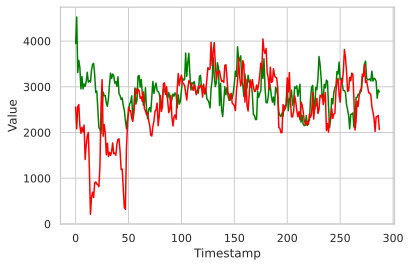

In [1422]:
import matplotlib.pyplot as plt

# plot single key 

slide_size = 24
start= WINDOW_SIZE*7
length = WINDOW_SIZE*6
print(start, length)
df = pd.read_csv(f"{dataset_dir}/{i}.csv")
print(f"{dataset_dir}/{i}.csv")
arr = df.value.values[:1200] # make same length
slide_times = [ts for ts in range(start, start + length, slide_size)]
print(slide_times)
print(i, slide_times, start, length)
y_pred, y_true = compute_policy_error(arr, slide_times, start, length)
print(mean_absolute_scaled_error(y_true, y_pred, y_train=y_true, sp=24))


x = range(len(y_true))

plt.plot(
    x, 
    y_true, 
    c ="green"
)

plt.plot(
    x, 
    y_pred, 
    c ="red"
)

plt.ylabel("Value")
plt.xlabel("Timestamp")
plt.show()

24 312


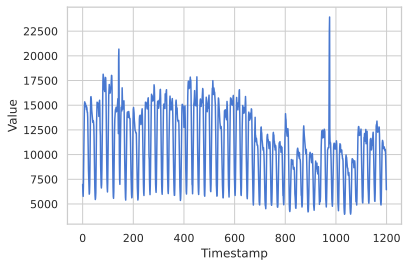

In [1037]:
import matplotlib.pyplot as plt

# plot single key 
i = 13
slide_size = 48
start= WINDOW_SIZE*1
length = WINDOW_SIZE*13
print(start, length)
df = pd.read_csv(f"{dataset_dir}/{i}.csv")
df.value.iloc[:1200].plot()

plt.ylabel("Value")
plt.xlabel("Timestamp")
plt.show()

[960, 966, 972, 978, 984, 990, 996, 1002, 1008, 1014, 1020, 1026, 1032, 1038, 1044, 1050, 1056, 1062, 1068, 1074, 1080, 1086, 1092, 1098, 1104, 1110, 1116, 1122, 1128, 1134, 1140, 1146, 1152, 1158, 1164, 1170, 1176, 1182, 1188, 1194, 1200, 1206, 1212, 1218, 1224, 1230, 1236, 1242, 1248, 1254, 1260, 1266, 1272, 1278, 1284, 1290, 1296, 1302, 1308, 1314, 1320, 1326, 1332, 1338]
1.150645530806771


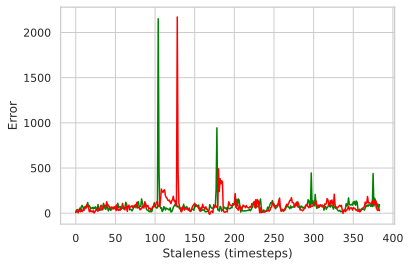

In [765]:
import matplotlib.pyplot as plt

# plot single key 

slide_size = 6
start= WINDOW_SIZE*10
length = WINDOW_SIZE*4
df = pd.read_csv(f"{dataset_dir}/{i}.csv")
arr = df.value.values[:1400] # make same length
slide_times = [ts for ts in range(start, start + length, slide_size)]
print(slide_times)
y_pred, y_true = compute_policy_error(arr, slide_times, start, length)
print(mean_absolute_scaled_error(y_true, y_pred, y_train=y_true, sp=24))


x = range(len(y_true))

plt.plot(
    x, 
    y_true, 
    c ="green"
)

plt.plot(
    x, 
    y_pred, 
    c ="red"
)

plt.ylabel("Error")
plt.xlabel("Staleness (timesteps)")
plt.show()

In [ ]:
# https://www.geeksforgeeks.org/how-to-download-historical-stock-prices-in-python/